# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 4.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

gpu_n = 0

torch.set_default_dtype(torch.float64)

#torch.autograd.set_detect_anomaly(True)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [7]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.8 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.8 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [8]:
# simpler
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [9]:
# # with regulation
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         x = self.dropout(x)
#         x = torch.softmax(self.fc2(x), dim=-1)
#         return x

In [10]:
# # more complex
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         # self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         # x = self.dropout(x)
#         x = torch.softmax(self.fc3(x), dim=-1)
#         return x

In [11]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    # initialize alpha parameters with more information, assuming some harmonies might be more probable
    alpha_h = pyro.param('alpha_h', (torch.ones(nharmonies, device=device) * 0.8), constraint=constraints.positive)

    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', (torch.ones([nharmonies, npcs], device=device) * 0.8), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    # net = AmortizationNetwork(input_dim=npcs, hidden_dim1=128, hidden_dim2=64, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [12]:
# def to_device_and_dtype(tensor, device):
#     return tensor.to(device).float()

In [13]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    #chord = torch.zeros(npcs).float()
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord
    #return to_device_and_dtype(chord, device)

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs
    # obs["c"] = torch.tensor([c['label'] for c in chords]).long()
    # obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords]).long()
    # return {k: to_device_and_dtype(v, device) for k, v in obs.items()}

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [14]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [15]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [16]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [17]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, step_size=100, clip_grad=0.1, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)

        # check for NaNs and infs in gradients
        for name, param in pyro.get_param_store().items():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    raise ValueError(f'Gradient for {name} has NaN/inf values.')

        # apply gradient clipping
        for p in pyro.get_param_store().values():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_grad, clip_grad))

        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [18]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [19]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [20]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  0%|          | 0/100000 [00:00<?, ?it/s]<ipython-input-17-390aaa289ab3>:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:
  0%|          | 5/100000 [00:00<38:03, 43.79it/s]

Step 0 : loss = 3727527.740960735


  0%|          | 108/100000 [00:02<36:30, 45.61it/s]

Step 100 : loss = 1913268.143297119


  0%|          | 208/100000 [00:04<37:50, 43.95it/s]

Step 200 : loss = 1876694.9396154908


  0%|          | 313/100000 [00:06<28:31, 58.24it/s]

Step 300 : loss = 1824524.2777314957


  0%|          | 407/100000 [00:08<27:50, 59.63it/s]

Step 400 : loss = 1830412.121077614


  1%|          | 512/100000 [00:10<28:18, 58.57it/s]

Step 500 : loss = 1844310.935343006


  1%|          | 608/100000 [00:11<27:26, 60.37it/s]

Step 600 : loss = 1802700.9836081816


  1%|          | 709/100000 [00:13<28:34, 57.91it/s]

Step 700 : loss = 1797449.0070959658


  1%|          | 810/100000 [00:15<28:36, 57.80it/s]

Step 800 : loss = 1811645.7077880027


  1%|          | 910/100000 [00:17<36:41, 45.00it/s]

Step 900 : loss = 1801612.5870756244


  1%|          | 1005/100000 [00:19<38:32, 42.81it/s]

Step 1000 : loss = 1807409.79153311


  1%|          | 1105/100000 [00:21<38:52, 42.41it/s]

Step 1100 : loss = 1807506.868748914


  1%|          | 1210/100000 [00:23<28:54, 56.96it/s]

Step 1200 : loss = 1802047.9550763704


  1%|▏         | 1307/100000 [00:25<28:47, 57.14it/s]

Step 1300 : loss = 1804000.3289574352


  1%|▏         | 1412/100000 [00:27<28:40, 57.31it/s]

Step 1400 : loss = 1798009.3288254524


  2%|▏         | 1512/100000 [00:28<26:49, 61.18it/s]

Step 1500 : loss = 1802647.901040993


  2%|▏         | 1612/100000 [00:30<27:23, 59.88it/s]

Step 1600 : loss = 1795650.1140994285


  2%|▏         | 1709/100000 [00:32<31:32, 51.93it/s]

Step 1700 : loss = 1804384.37594035


  2%|▏         | 1805/100000 [00:34<36:34, 44.74it/s]

Step 1800 : loss = 1798994.8717052075


  2%|▏         | 1910/100000 [00:36<37:19, 43.81it/s]

Step 1900 : loss = 1823923.8461622675


  2%|▏         | 2010/100000 [00:38<27:53, 58.57it/s]

Step 2000 : loss = 1798031.1856685674


  2%|▏         | 2108/100000 [00:40<26:44, 61.02it/s]

Step 2100 : loss = 1798036.2999801734


  2%|▏         | 2208/100000 [00:42<26:40, 61.10it/s]

Step 2200 : loss = 1801610.5368152342


  2%|▏         | 2312/100000 [00:43<27:23, 59.43it/s]

Step 2300 : loss = 1789964.6794468153


  2%|▏         | 2412/100000 [00:45<26:59, 60.28it/s]

Step 2400 : loss = 1808858.1983744088


  3%|▎         | 2511/100000 [00:47<28:20, 57.34it/s]

Step 2500 : loss = 1806527.2989830822


  3%|▎         | 2608/100000 [00:49<36:59, 43.88it/s]

Step 2600 : loss = 1796941.2507511275


  3%|▎         | 2708/100000 [00:51<35:50, 45.24it/s]

Step 2700 : loss = 1806659.394594719


  3%|▎         | 2810/100000 [00:53<33:07, 48.91it/s]

Step 2800 : loss = 1784635.7783121546


  3%|▎         | 2910/100000 [00:55<27:38, 58.55it/s]

Step 2900 : loss = 1789486.630952848


  3%|▎         | 3010/100000 [00:57<26:43, 60.49it/s]

Step 3000 : loss = 1798591.6415197402


  3%|▎         | 3109/100000 [00:58<26:46, 60.33it/s]

Step 3100 : loss = 1805362.6299967968


  3%|▎         | 3211/100000 [01:00<27:37, 58.39it/s]

Step 3200 : loss = 1803404.1553980317


  3%|▎         | 3312/100000 [01:02<26:35, 60.60it/s]

Step 3300 : loss = 1791879.2512499702


  3%|▎         | 3408/100000 [01:04<33:47, 47.64it/s]

Step 3400 : loss = 1803480.411953473


  4%|▎         | 3508/100000 [01:06<38:53, 41.36it/s]

Step 3500 : loss = 1806901.1944529843


  4%|▎         | 3608/100000 [01:08<37:19, 43.05it/s]

Step 3600 : loss = 1810638.114981004


  4%|▎         | 3706/100000 [01:10<28:39, 55.99it/s]

Step 3700 : loss = 1803035.0210311576


  4%|▍         | 3811/100000 [01:12<26:31, 60.45it/s]

Step 3800 : loss = 1802308.8296658564


  4%|▍         | 3913/100000 [01:14<26:32, 60.33it/s]

Step 3900 : loss = 1800582.3239382936


  4%|▍         | 4012/100000 [01:15<27:27, 58.26it/s]

Step 4000 : loss = 1805442.7120791236


  4%|▍         | 4111/100000 [01:17<26:27, 60.41it/s]

Step 4100 : loss = 1794264.6690940661


  4%|▍         | 4209/100000 [01:19<27:02, 59.05it/s]

Step 4200 : loss = 1792281.1846584042


  4%|▍         | 4309/100000 [01:22<37:01, 43.08it/s]

Step 4300 : loss = 1792361.607350723


  4%|▍         | 4409/100000 [01:24<37:44, 42.21it/s]

Step 4400 : loss = 1808836.3690819293


  5%|▍         | 4507/100000 [01:26<27:47, 57.26it/s]

Step 4500 : loss = 1810273.068050196


  5%|▍         | 4612/100000 [01:28<26:20, 60.37it/s]

Step 4600 : loss = 1791031.6093768517


  5%|▍         | 4709/100000 [01:29<26:57, 58.91it/s]

Step 4700 : loss = 1792561.6351798584


  5%|▍         | 4813/100000 [01:31<25:44, 61.62it/s]

Step 4800 : loss = 1790873.9313173883


  5%|▍         | 4910/100000 [01:33<26:21, 60.14it/s]

Step 4900 : loss = 1810983.6890337844


  5%|▌         | 5012/100000 [01:34<26:33, 59.61it/s]

Step 5000 : loss = 1807186.539067604


  5%|▌         | 5110/100000 [01:36<34:43, 45.54it/s]

Step 5100 : loss = 1805738.2916318506


  5%|▌         | 5210/100000 [01:39<35:40, 44.29it/s]

Step 5200 : loss = 1800106.5518083475


  5%|▌         | 5305/100000 [01:41<38:20, 41.16it/s]

Step 5300 : loss = 1799906.0728116923


  5%|▌         | 5411/100000 [01:43<25:53, 60.88it/s]

Step 5400 : loss = 1810509.2452086965


  6%|▌         | 5509/100000 [01:44<26:38, 59.11it/s]

Step 5500 : loss = 1789626.1296002427


  6%|▌         | 5608/100000 [01:46<26:51, 58.59it/s]

Step 5600 : loss = 1804295.91520201


  6%|▌         | 5711/100000 [01:48<26:34, 59.12it/s]

Step 5700 : loss = 1837188.10391832


  6%|▌         | 5809/100000 [01:49<26:21, 59.57it/s]

Step 5800 : loss = 1807567.9843394025


  6%|▌         | 5905/100000 [01:51<25:10, 62.30it/s]

Step 5900 : loss = 1796779.7607264952


  6%|▌         | 6010/100000 [01:53<34:46, 45.04it/s]

Step 6000 : loss = 1798949.4813220534


  6%|▌         | 6105/100000 [01:56<37:24, 41.82it/s]

Step 6100 : loss = 1812102.8856500078


  6%|▌         | 6209/100000 [01:58<27:38, 56.54it/s]

Step 6200 : loss = 1797096.8018081794


  6%|▋         | 6312/100000 [02:00<26:06, 59.82it/s]

Step 6300 : loss = 1796699.54354815


  6%|▋         | 6413/100000 [02:01<25:23, 61.45it/s]

Step 6400 : loss = 1793754.0165734338


  7%|▋         | 6511/100000 [02:03<26:43, 58.32it/s]

Step 6500 : loss = 1802546.379490303


  7%|▋         | 6608/100000 [02:04<25:53, 60.11it/s]

Step 6600 : loss = 1796825.2073690463


  7%|▋         | 6708/100000 [02:06<26:44, 58.16it/s]

Step 6700 : loss = 1802160.6698924955


  7%|▋         | 6810/100000 [02:08<34:58, 44.40it/s]

Step 6800 : loss = 1807374.3449129579


  7%|▋         | 6905/100000 [02:10<36:58, 41.97it/s]

Step 6900 : loss = 1788481.3803077661


  7%|▋         | 7005/100000 [02:13<35:49, 43.26it/s]

Step 7000 : loss = 1801629.971686329


  7%|▋         | 7109/100000 [02:15<26:34, 58.26it/s]

Step 7100 : loss = 1789859.5252911593


  7%|▋         | 7208/100000 [02:16<25:52, 59.76it/s]

Step 7200 : loss = 1808221.2544448166


  7%|▋         | 7309/100000 [02:18<25:21, 60.94it/s]

Step 7300 : loss = 1797276.1256986521


  7%|▋         | 7407/100000 [02:19<25:54, 59.55it/s]

Step 7400 : loss = 1803787.6486538325


  8%|▊         | 7512/100000 [02:21<25:00, 61.64it/s]

Step 7500 : loss = 1808373.4513989836


  8%|▊         | 7608/100000 [02:23<26:15, 58.64it/s]

Step 7600 : loss = 1798516.3605935853


  8%|▊         | 7706/100000 [02:25<34:56, 44.01it/s]

Step 7700 : loss = 1782129.6312235827


  8%|▊         | 7806/100000 [02:27<34:17, 44.81it/s]

Step 7800 : loss = 1807985.873049744


  8%|▊         | 7907/100000 [02:29<26:06, 58.79it/s]

Step 7900 : loss = 1794652.3063661624


  8%|▊         | 8011/100000 [02:31<25:13, 60.79it/s]

Step 8000 : loss = 1809475.6646687281


  8%|▊         | 8109/100000 [02:33<24:56, 61.41it/s]

Step 8100 : loss = 1793819.4030448566


  8%|▊         | 8208/100000 [02:34<26:38, 57.44it/s]

Step 8200 : loss = 1808928.941171818


  8%|▊         | 8308/100000 [02:36<25:41, 59.47it/s]

Step 8300 : loss = 1799857.1142474785


  8%|▊         | 8410/100000 [02:38<25:14, 60.49it/s]

Step 8400 : loss = 1795375.025310771


  9%|▊         | 8508/100000 [02:40<34:10, 44.62it/s]

Step 8500 : loss = 1791150.0172567163


  9%|▊         | 8608/100000 [02:42<33:45, 45.12it/s]

Step 8600 : loss = 1810398.7464569914


  9%|▊         | 8708/100000 [02:44<35:38, 42.69it/s]

Step 8700 : loss = 1789196.6233112041


  9%|▉         | 8807/100000 [02:46<25:12, 60.29it/s]

Step 8800 : loss = 1811566.7576323405


  9%|▉         | 8906/100000 [02:48<26:34, 57.12it/s]

Step 8900 : loss = 1814535.1169150022


  9%|▉         | 9009/100000 [02:49<25:01, 60.61it/s]

Step 9000 : loss = 1799988.7961399532


  9%|▉         | 9113/100000 [02:51<24:31, 61.76it/s]

Step 9100 : loss = 1809727.9611456904


  9%|▉         | 9210/100000 [02:53<26:02, 58.09it/s]

Step 9200 : loss = 1794709.6056308625


  9%|▉         | 9310/100000 [02:55<26:44, 56.52it/s]

Step 9300 : loss = 1787895.292192827


  9%|▉         | 9407/100000 [02:57<35:14, 42.84it/s]

Step 9400 : loss = 1809654.2529070184


 10%|▉         | 9507/100000 [02:59<33:20, 45.23it/s]

Step 9500 : loss = 1808416.5356912515


 10%|▉         | 9609/100000 [03:01<25:00, 60.26it/s]

Step 9600 : loss = 1799112.9477583547


 10%|▉         | 9711/100000 [03:03<24:58, 60.24it/s]

Step 9700 : loss = 1805889.668186477


 10%|▉         | 9810/100000 [03:05<25:56, 57.94it/s]

Step 9800 : loss = 1809443.3072352144


 10%|▉         | 9912/100000 [03:06<24:59, 60.07it/s]

Step 9900 : loss = 1802759.8812996438


 10%|█         | 10010/100000 [03:08<24:47, 60.49it/s]

Step 10000 : loss = 1806953.9831997552


 10%|█         | 10111/100000 [03:10<26:19, 56.92it/s]

Step 10100 : loss = 1804980.6454244298


 10%|█         | 10208/100000 [03:12<33:38, 44.49it/s]

Step 10200 : loss = 1806447.6752332938


 10%|█         | 10308/100000 [03:14<35:16, 42.39it/s]

Step 10300 : loss = 1803961.630107541


 10%|█         | 10405/100000 [03:16<43:31, 34.30it/s]

Step 10400 : loss = 1808021.8772410033


 11%|█         | 10510/100000 [03:19<34:31, 43.20it/s]

Step 10500 : loss = 1802196.2109408532


 11%|█         | 10610/100000 [03:21<33:57, 43.87it/s]

Step 10600 : loss = 1792494.3801072417


 11%|█         | 10713/100000 [03:23<24:59, 59.53it/s]

Step 10700 : loss = 1796859.1723643537


 11%|█         | 10807/100000 [03:25<25:28, 58.36it/s]

Step 10800 : loss = 1807072.817325532


 11%|█         | 10912/100000 [03:27<25:27, 58.33it/s]

Step 10900 : loss = 1794538.173716764


 11%|█         | 11009/100000 [03:29<34:00, 43.60it/s]

Step 11000 : loss = 1791318.8409288255


 11%|█         | 11109/100000 [03:31<32:55, 45.00it/s]

Step 11100 : loss = 1794284.51068762


 11%|█         | 11207/100000 [03:33<29:46, 49.71it/s]

Step 11200 : loss = 1794350.931321001


 11%|█▏        | 11307/100000 [03:35<24:57, 59.24it/s]

Step 11300 : loss = 1795981.0610797654


 11%|█▏        | 11410/100000 [03:37<24:35, 60.03it/s]

Step 11400 : loss = 1796034.4614613494


 12%|█▏        | 11508/100000 [03:38<24:44, 59.62it/s]

Step 11500 : loss = 1787151.8670856124


 12%|█▏        | 11608/100000 [03:40<24:09, 60.98it/s]

Step 11600 : loss = 1802189.9326534073


 12%|█▏        | 11708/100000 [03:42<24:25, 60.23it/s]

Step 11700 : loss = 1807151.024031178


 12%|█▏        | 11805/100000 [03:43<29:20, 50.10it/s]

Step 11800 : loss = 1808517.8232276712


 12%|█▏        | 11906/100000 [03:46<34:28, 42.58it/s]

Step 11900 : loss = 1805409.692798362


 12%|█▏        | 12006/100000 [03:48<32:54, 44.56it/s]

Step 12000 : loss = 1802002.0624803258


 12%|█▏        | 12110/100000 [03:50<24:38, 59.44it/s]

Step 12100 : loss = 1811682.6499570636


 12%|█▏        | 12211/100000 [03:52<23:53, 61.25it/s]

Step 12200 : loss = 1803123.9880244173


 12%|█▏        | 12313/100000 [03:53<24:20, 60.05it/s]

Step 12300 : loss = 1795848.7763008396


 12%|█▏        | 12410/100000 [03:55<24:44, 59.01it/s]

Step 12400 : loss = 1798767.2523958075


 13%|█▎        | 12511/100000 [03:57<24:30, 59.50it/s]

Step 12500 : loss = 1789244.4315087607


 13%|█▎        | 12613/100000 [03:58<24:22, 59.77it/s]

Step 12600 : loss = 1796777.2914638924


 13%|█▎        | 12706/100000 [04:00<32:22, 44.94it/s]

Step 12700 : loss = 1800050.733971024


 13%|█▎        | 12806/100000 [04:03<31:58, 45.45it/s]

Step 12800 : loss = 1811707.5860446796


 13%|█▎        | 12910/100000 [04:05<26:49, 54.12it/s]

Step 12900 : loss = 1810980.005087974


 13%|█▎        | 13009/100000 [04:07<24:41, 58.73it/s]

Step 13000 : loss = 1797046.4593014242


 13%|█▎        | 13109/100000 [04:08<25:08, 57.58it/s]

Step 13100 : loss = 1801863.927011652


 13%|█▎        | 13210/100000 [04:10<24:48, 58.30it/s]

Step 13200 : loss = 1798672.3519907964


 13%|█▎        | 13311/100000 [04:12<23:56, 60.37it/s]

Step 13300 : loss = 1790777.1529607251


 13%|█▎        | 13409/100000 [04:13<23:41, 60.92it/s]

Step 13400 : loss = 1813519.5474485971


 14%|█▎        | 13506/100000 [04:15<31:15, 46.12it/s]

Step 13500 : loss = 1796285.8994774711


 14%|█▎        | 13606/100000 [04:18<33:27, 43.04it/s]

Step 13600 : loss = 1783603.730111805


 14%|█▎        | 13706/100000 [04:20<34:11, 42.06it/s]

Step 13700 : loss = 1797077.7630679708


 14%|█▍        | 13809/100000 [04:22<24:30, 58.61it/s]

Step 13800 : loss = 1806962.648055002


 14%|█▍        | 13911/100000 [04:23<24:09, 59.39it/s]

Step 13900 : loss = 1800109.4247566515


 14%|█▍        | 14009/100000 [04:25<25:06, 57.07it/s]

Step 14000 : loss = 1806232.6651641657


 14%|█▍        | 14107/100000 [04:27<24:08, 59.28it/s]

Step 14100 : loss = 1795476.654831043


 14%|█▍        | 14208/100000 [04:29<24:26, 58.50it/s]

Step 14200 : loss = 1797134.7223814046


 14%|█▍        | 14312/100000 [04:30<25:19, 56.38it/s]

Step 14300 : loss = 1805344.992292236


 14%|█▍        | 14409/100000 [04:33<32:53, 43.37it/s]

Step 14400 : loss = 1800759.4303930928


 15%|█▍        | 14509/100000 [04:35<33:43, 42.25it/s]

Step 14500 : loss = 1783261.3301967804


 15%|█▍        | 14608/100000 [04:37<24:24, 58.30it/s]

Step 14600 : loss = 1791030.0360302436


 15%|█▍        | 14713/100000 [04:39<23:51, 59.59it/s]

Step 14700 : loss = 1796526.6076412518


 15%|█▍        | 14809/100000 [04:41<24:24, 58.18it/s]

Step 14800 : loss = 1798662.5319208838


 15%|█▍        | 14908/100000 [04:42<24:34, 57.71it/s]

Step 14900 : loss = 1800782.9587409014


 15%|█▌        | 15009/100000 [04:44<24:01, 58.95it/s]

Step 15000 : loss = 1802210.7257447992


 15%|█▌        | 15106/100000 [04:46<25:16, 55.99it/s]

Step 15100 : loss = 1788436.1619021548


 15%|█▌        | 15209/100000 [04:48<31:58, 44.21it/s]

Step 15200 : loss = 1796588.5781124425


 15%|█▌        | 15309/100000 [04:50<33:15, 42.44it/s]

Step 15300 : loss = 1782305.1563691269


 15%|█▌        | 15407/100000 [04:52<28:10, 50.05it/s]

Step 15400 : loss = 1785727.3400785767


 16%|█▌        | 15506/100000 [04:54<25:17, 55.69it/s]

Step 15500 : loss = 1790673.0623334006


 16%|█▌        | 15610/100000 [04:56<24:06, 58.35it/s]

Step 15600 : loss = 1790695.1677809572


 16%|█▌        | 15709/100000 [04:58<24:01, 58.48it/s]

Step 15700 : loss = 1812879.7268659025


 16%|█▌        | 15809/100000 [05:00<24:51, 56.46it/s]

Step 15800 : loss = 1801232.3325262652


 16%|█▌        | 15906/100000 [05:01<22:56, 61.10it/s]

Step 15900 : loss = 1783229.0638665154


 16%|█▌        | 16007/100000 [05:03<32:49, 42.66it/s]

Step 16000 : loss = 1797135.3092599562


 16%|█▌        | 16107/100000 [05:06<33:30, 41.73it/s]

Step 16100 : loss = 1812869.2645775282


 16%|█▌        | 16207/100000 [05:08<33:15, 41.98it/s]

Step 16200 : loss = 1811276.0058648905


 16%|█▋        | 16312/100000 [05:10<24:47, 56.26it/s]

Step 16300 : loss = 1809525.337628031


 16%|█▋        | 16409/100000 [05:12<24:20, 57.24it/s]

Step 16400 : loss = 1798522.4433486615


 17%|█▋        | 16509/100000 [05:13<24:10, 57.54it/s]

Step 16500 : loss = 1795217.5933688993


 17%|█▋        | 16609/100000 [05:15<24:05, 57.68it/s]

Step 16600 : loss = 1797086.207062367


 17%|█▋        | 16712/100000 [05:17<23:47, 58.36it/s]

Step 16700 : loss = 1796157.5316569144


 17%|█▋        | 16810/100000 [05:19<31:50, 43.54it/s]

Step 16800 : loss = 1797931.0120738468


 17%|█▋        | 16910/100000 [05:21<31:06, 44.52it/s]

Step 16900 : loss = 1800034.3846611204


 17%|█▋        | 17005/100000 [05:23<34:19, 40.29it/s]

Step 17000 : loss = 1799472.2104543915


 17%|█▋        | 17110/100000 [05:26<25:42, 53.73it/s]

Step 17100 : loss = 1793849.3455995163


 17%|█▋        | 17208/100000 [05:28<23:43, 58.17it/s]

Step 17200 : loss = 1809735.5910541744


 17%|█▋        | 17308/100000 [05:29<23:26, 58.81it/s]

Step 17300 : loss = 1789613.2290641295


 17%|█▋        | 17408/100000 [05:31<23:13, 59.25it/s]

Step 17400 : loss = 1800602.7654456012


 18%|█▊        | 17508/100000 [05:33<23:51, 57.63it/s]

Step 17500 : loss = 1800005.131869908


 18%|█▊        | 17606/100000 [05:35<30:51, 44.50it/s]

Step 17600 : loss = 1787640.938934011


 18%|█▊        | 17706/100000 [05:37<31:43, 43.24it/s]

Step 17700 : loss = 1805591.740271761


 18%|█▊        | 17806/100000 [05:39<33:50, 40.48it/s]

Step 17800 : loss = 1793239.8955460773


 18%|█▊        | 17909/100000 [05:41<24:31, 55.78it/s]

Step 17900 : loss = 1808619.702661749


 18%|█▊        | 18010/100000 [05:43<22:57, 59.53it/s]

Step 18000 : loss = 1789484.1723761265


 18%|█▊        | 18108/100000 [05:45<24:06, 56.63it/s]

Step 18100 : loss = 1787870.7490599875


 18%|█▊        | 18210/100000 [05:46<23:54, 57.00it/s]

Step 18200 : loss = 1791422.9736126047


 18%|█▊        | 18310/100000 [05:48<23:00, 59.15it/s]

Step 18300 : loss = 1800447.322289526


 18%|█▊        | 18405/100000 [05:50<23:34, 57.69it/s]

Step 18400 : loss = 1805603.2533788953


 19%|█▊        | 18508/100000 [05:52<30:08, 45.07it/s]

Step 18500 : loss = 1798572.0484232483


 19%|█▊        | 18608/100000 [05:55<31:38, 42.88it/s]

Step 18600 : loss = 1789178.5332866958


 19%|█▊        | 18709/100000 [05:57<23:43, 57.13it/s]

Step 18700 : loss = 1819519.855809011


 19%|█▉        | 18810/100000 [05:58<23:26, 57.72it/s]

Step 18800 : loss = 1796682.5552152693


 19%|█▉        | 18909/100000 [06:00<23:25, 57.70it/s]

Step 18900 : loss = 1803257.9283243394


 19%|█▉        | 19010/100000 [06:02<23:01, 58.64it/s]

Step 19000 : loss = 1794241.359583906


 19%|█▉        | 19108/100000 [06:03<23:20, 57.77it/s]

Step 19100 : loss = 1786766.3979688454


 19%|█▉        | 19208/100000 [06:05<23:24, 57.53it/s]

Step 19200 : loss = 1808555.3843820407


 19%|█▉        | 19307/100000 [06:07<31:50, 42.23it/s]

Step 19300 : loss = 1799591.7784664521


 19%|█▉        | 19407/100000 [06:10<31:22, 42.81it/s]

Step 19400 : loss = 1819444.5707617481


 20%|█▉        | 19510/100000 [06:12<26:06, 51.38it/s]

Step 19500 : loss = 1798470.2247245167


 20%|█▉        | 19608/100000 [06:14<23:24, 57.25it/s]

Step 19600 : loss = 1794493.527963994


 20%|█▉        | 19712/100000 [06:16<23:20, 57.32it/s]

Step 19700 : loss = 1796701.3329066266


 20%|█▉        | 19810/100000 [06:17<22:27, 59.52it/s]

Step 19800 : loss = 1800418.2761592125


 20%|█▉        | 19912/100000 [06:19<22:40, 58.85it/s]

Step 19900 : loss = 1795720.833813252


 20%|██        | 20013/100000 [06:21<22:12, 60.01it/s]

Step 20000 : loss = 1802495.8140844267


 20%|██        | 20108/100000 [06:23<29:57, 44.45it/s]

Step 20100 : loss = 1792359.0131518517


 20%|██        | 20208/100000 [06:25<31:05, 42.78it/s]

Step 20200 : loss = 1798423.516773459


 20%|██        | 20308/100000 [06:27<31:22, 42.34it/s]

Step 20300 : loss = 1802185.5655741864


 20%|██        | 20413/100000 [06:29<22:04, 60.07it/s]

Step 20400 : loss = 1795226.6659295023


 21%|██        | 20508/100000 [06:31<22:15, 59.54it/s]

Step 20500 : loss = 1810200.7787858094


 21%|██        | 20610/100000 [06:32<22:49, 57.99it/s]

Step 20600 : loss = 1783767.5582245728


 21%|██        | 20708/100000 [06:34<22:09, 59.64it/s]

Step 20700 : loss = 1783630.402812682


 21%|██        | 20810/100000 [06:36<22:57, 57.47it/s]

Step 20800 : loss = 1800750.6562320252


 21%|██        | 20907/100000 [06:38<25:54, 50.89it/s]

Step 20900 : loss = 1807073.7060307404


 21%|██        | 21008/100000 [06:40<31:01, 42.43it/s]

Step 21000 : loss = 1797061.4931959144


 21%|██        | 21108/100000 [06:42<30:10, 43.58it/s]

Step 21100 : loss = 1799329.2083448688


 21%|██        | 21209/100000 [06:44<22:53, 57.38it/s]

Step 21200 : loss = 1787233.1908694056


 21%|██▏       | 21308/100000 [06:46<22:45, 57.61it/s]

Step 21300 : loss = 1805305.9754714258


 21%|██▏       | 21412/100000 [06:48<22:22, 58.56it/s]

Step 21400 : loss = 1802997.977299506


 22%|██▏       | 21512/100000 [06:50<22:58, 56.94it/s]

Step 21500 : loss = 1792684.6272690678


 22%|██▏       | 21610/100000 [06:51<22:50, 57.19it/s]

Step 21600 : loss = 1801851.6090163551


 22%|██▏       | 21710/100000 [06:53<21:45, 59.99it/s]

Step 21700 : loss = 1795622.1465069768


 22%|██▏       | 21806/100000 [06:55<30:26, 42.80it/s]

Step 21800 : loss = 1811767.2928734957


 22%|██▏       | 21906/100000 [06:58<31:24, 41.43it/s]

Step 21900 : loss = 1788816.6060594406


 22%|██▏       | 22009/100000 [07:00<25:00, 51.97it/s]

Step 22000 : loss = 1795596.515077552


 22%|██▏       | 22108/100000 [07:01<21:50, 59.43it/s]

Step 22100 : loss = 1820929.003160377


 22%|██▏       | 22210/100000 [07:03<21:53, 59.24it/s]

Step 22200 : loss = 1799226.8048886447


 22%|██▏       | 22308/100000 [07:05<23:45, 54.52it/s]

Step 22300 : loss = 1797932.22303761


 22%|██▏       | 22412/100000 [07:07<22:56, 56.37it/s]

Step 22400 : loss = 1796910.8100872547


 23%|██▎       | 22508/100000 [07:08<22:35, 57.16it/s]

Step 22500 : loss = 1806051.4667044198


 23%|██▎       | 22608/100000 [07:11<29:50, 43.21it/s]

Step 22600 : loss = 1803718.169905242


 23%|██▎       | 22708/100000 [07:13<28:39, 44.94it/s]

Step 22700 : loss = 1794268.696996532


 23%|██▎       | 22808/100000 [07:15<32:02, 40.14it/s]

Step 22800 : loss = 1793518.1206030843


 23%|██▎       | 22908/100000 [07:17<21:56, 58.56it/s]

Step 22900 : loss = 1789155.887091484


 23%|██▎       | 23008/100000 [07:19<22:22, 57.36it/s]

Step 23000 : loss = 1800559.9432678062


 23%|██▎       | 23112/100000 [07:21<22:50, 56.11it/s]

Step 23100 : loss = 1797567.7368961992


 23%|██▎       | 23212/100000 [07:22<21:07, 60.58it/s]

Step 23200 : loss = 1801455.7994098843


 23%|██▎       | 23311/100000 [07:24<21:57, 58.23it/s]

Step 23300 : loss = 1806584.8514171825


 23%|██▎       | 23405/100000 [07:26<29:41, 42.99it/s]

Step 23400 : loss = 1790755.152554086


 24%|██▎       | 23510/100000 [07:28<29:19, 43.48it/s]

Step 23500 : loss = 1797111.2364960662


 24%|██▎       | 23605/100000 [07:31<30:05, 42.32it/s]

Step 23600 : loss = 1795809.3152908224


 24%|██▎       | 23709/100000 [07:33<21:32, 59.04it/s]

Step 23700 : loss = 1815564.0349334553


 24%|██▍       | 23807/100000 [07:35<29:02, 43.73it/s]

Step 23800 : loss = 1809083.9824222457


 24%|██▍       | 23907/100000 [07:37<29:40, 42.74it/s]

Step 23900 : loss = 1804893.4898732577


 24%|██▍       | 24007/100000 [07:39<31:10, 40.62it/s]

Step 24000 : loss = 1799730.4195881572


 24%|██▍       | 24113/100000 [07:41<21:25, 59.01it/s]

Step 24100 : loss = 1787237.827708349


 24%|██▍       | 24210/100000 [07:43<27:26, 46.03it/s]

Step 24200 : loss = 1796194.920962518


 24%|██▍       | 24305/100000 [07:46<29:27, 42.82it/s]

Step 24300 : loss = 1796212.4227783824


 24%|██▍       | 24411/100000 [07:48<23:15, 54.17it/s]

Step 24400 : loss = 1797187.613219317


 25%|██▍       | 24509/100000 [07:50<21:17, 59.10it/s]

Step 24500 : loss = 1804284.0649081822


 25%|██▍       | 24608/100000 [07:51<21:48, 57.62it/s]

Step 24600 : loss = 1800988.1063011768


 25%|██▍       | 24708/100000 [07:53<22:05, 56.82it/s]

Step 24700 : loss = 1799453.4710061708


 25%|██▍       | 24812/100000 [07:55<21:58, 57.04it/s]

Step 24800 : loss = 1800091.299601649


 25%|██▍       | 24910/100000 [07:57<21:56, 57.04it/s]

Step 24900 : loss = 1798137.8760713595


 25%|██▌       | 25007/100000 [07:59<28:34, 43.73it/s]

Step 25000 : loss = 1797397.9206878257


 25%|██▌       | 25107/100000 [08:01<28:19, 44.07it/s]

Step 25100 : loss = 1802658.907675722


 25%|██▌       | 25208/100000 [08:03<28:08, 44.29it/s]

Step 25200 : loss = 1814222.9831113275


 25%|██▌       | 25311/100000 [08:05<21:16, 58.52it/s]

Step 25300 : loss = 1797151.1858646148


 25%|██▌       | 25412/100000 [08:07<21:35, 57.56it/s]

Step 25400 : loss = 1795759.8621277276


 26%|██▌       | 25512/100000 [08:09<21:28, 57.79it/s]

Step 25500 : loss = 1789287.8026645305


 26%|██▌       | 25610/100000 [08:10<21:07, 58.68it/s]

Step 25600 : loss = 1786330.557711035


 26%|██▌       | 25710/100000 [08:12<21:29, 57.60it/s]

Step 25700 : loss = 1797021.702838256


 26%|██▌       | 25806/100000 [08:14<27:48, 44.46it/s]

Step 25800 : loss = 1788665.15830975


 26%|██▌       | 25906/100000 [08:16<29:58, 41.19it/s]

Step 25900 : loss = 1803735.3534740135


 26%|██▌       | 26006/100000 [08:19<28:03, 43.96it/s]

Step 26000 : loss = 1802322.8721668115


 26%|██▌       | 26113/100000 [08:21<20:59, 58.66it/s]

Step 26100 : loss = 1792690.026647342


 26%|██▌       | 26212/100000 [08:22<21:48, 56.37it/s]

Step 26200 : loss = 1792889.9650087662


 26%|██▋       | 26308/100000 [08:24<21:16, 57.75it/s]

Step 26300 : loss = 1808035.4007447383


 26%|██▋       | 26411/100000 [08:26<21:28, 57.13it/s]

Step 26400 : loss = 1793256.5821501934


 27%|██▋       | 26510/100000 [08:28<21:32, 56.84it/s]

Step 26500 : loss = 1796874.229114045


 27%|██▋       | 26608/100000 [08:29<20:15, 60.40it/s]

Step 26600 : loss = 1799874.6073932934


 27%|██▋       | 26707/100000 [08:31<27:07, 45.03it/s]

Step 26700 : loss = 1798399.5638183458


 27%|██▋       | 26807/100000 [08:34<28:24, 42.94it/s]

Step 26800 : loss = 1792818.5288982205


 27%|██▋       | 26908/100000 [08:36<22:34, 53.98it/s]

Step 26900 : loss = 1799670.5861332053


 27%|██▋       | 27011/100000 [08:38<20:44, 58.67it/s]

Step 27000 : loss = 1817936.3327392414


 27%|██▋       | 27108/100000 [08:39<21:49, 55.66it/s]

Step 27100 : loss = 1794920.2325376095


 27%|██▋       | 27213/100000 [08:41<20:38, 58.79it/s]

Step 27200 : loss = 1789912.4572648965


 27%|██▋       | 27312/100000 [08:43<20:11, 60.00it/s]

Step 27300 : loss = 1814549.2378047497


 27%|██▋       | 27411/100000 [08:45<21:16, 56.87it/s]

Step 27400 : loss = 1799993.3427307154


 28%|██▊       | 27505/100000 [08:47<28:52, 41.84it/s]

Step 27500 : loss = 1803537.788118638


 28%|██▊       | 27610/100000 [08:49<26:57, 44.76it/s]

Step 27600 : loss = 1789753.5155077856


 28%|██▊       | 27712/100000 [08:51<25:14, 47.75it/s]

Step 27700 : loss = 1792611.4738667167


 28%|██▊       | 27810/100000 [08:53<20:51, 57.70it/s]

Step 27800 : loss = 1805065.5272830876


 28%|██▊       | 27908/100000 [08:55<21:31, 55.82it/s]

Step 27900 : loss = 1807693.6683291765


 28%|██▊       | 28012/100000 [08:57<21:05, 56.88it/s]

Step 28000 : loss = 1793587.1776083442


 28%|██▊       | 28111/100000 [08:58<20:02, 59.76it/s]

Step 28100 : loss = 1795766.6471286777


 28%|██▊       | 28208/100000 [09:00<20:11, 59.24it/s]

Step 28200 : loss = 1797231.567586727


 28%|██▊       | 28310/100000 [09:02<26:22, 45.29it/s]

Step 28300 : loss = 1798928.4497132986


 28%|██▊       | 28410/100000 [09:04<27:43, 43.03it/s]

Step 28400 : loss = 1790158.6279122299


 29%|██▊       | 28509/100000 [09:07<27:29, 43.34it/s]

Step 28500 : loss = 1796346.0273804176


 29%|██▊       | 28608/100000 [09:09<20:52, 56.98it/s]

Step 28600 : loss = 1802091.3932211567


 29%|██▊       | 28707/100000 [09:10<21:02, 56.47it/s]

Step 28700 : loss = 1801047.0831522876


 29%|██▉       | 28809/100000 [09:12<20:10, 58.81it/s]

Step 28800 : loss = 1790468.9554483532


 29%|██▉       | 28912/100000 [09:14<20:50, 56.83it/s]

Step 28900 : loss = 1793689.0200711316


 29%|██▉       | 29010/100000 [09:16<21:29, 55.04it/s]

Step 29000 : loss = 1800025.121910881


 29%|██▉       | 29107/100000 [09:17<20:30, 57.61it/s]

Step 29100 : loss = 1795740.4027528868


 29%|██▉       | 29205/100000 [09:19<26:56, 43.81it/s]

Step 29200 : loss = 1801276.6520200244


 29%|██▉       | 29305/100000 [09:22<27:22, 43.04it/s]

Step 29300 : loss = 1796374.7453141897


 29%|██▉       | 29412/100000 [09:24<21:19, 55.17it/s]

Step 29400 : loss = 1793481.6783718644


 30%|██▉       | 29510/100000 [09:26<21:29, 54.65it/s]

Step 29500 : loss = 1780143.9668464318


 30%|██▉       | 29609/100000 [09:28<20:06, 58.36it/s]

Step 29600 : loss = 1803759.5408727066


 30%|██▉       | 29708/100000 [09:29<20:29, 57.17it/s]

Step 29700 : loss = 1793896.1048695035


 30%|██▉       | 29807/100000 [09:31<19:48, 59.06it/s]

Step 29800 : loss = 1794678.1917598974


 30%|██▉       | 29911/100000 [09:33<20:37, 56.63it/s]

Step 29900 : loss = 1799898.2200137996


 30%|███       | 30005/100000 [09:35<27:05, 43.05it/s]

Step 30000 : loss = 1797091.6802330208


 30%|███       | 30110/100000 [09:37<26:07, 44.59it/s]

Step 30100 : loss = 1802318.1659636798


 30%|███       | 30211/100000 [09:40<25:25, 45.74it/s]

Step 30200 : loss = 1789472.439328319


 30%|███       | 30307/100000 [09:41<19:29, 59.57it/s]

Step 30300 : loss = 1808908.5261221416


 30%|███       | 30407/100000 [09:43<19:37, 59.10it/s]

Step 30400 : loss = 1790822.6312282125


 31%|███       | 30507/100000 [09:45<19:42, 58.77it/s]

Step 30500 : loss = 1804616.1645197417


 31%|███       | 30612/100000 [09:46<19:35, 59.01it/s]

Step 30600 : loss = 1807325.4946152829


 31%|███       | 30711/100000 [09:48<19:51, 58.15it/s]

Step 30700 : loss = 1787123.3140079856


 31%|███       | 30808/100000 [09:50<26:02, 44.28it/s]

Step 30800 : loss = 1787463.7773483


 31%|███       | 30908/100000 [09:52<27:47, 41.43it/s]

Step 30900 : loss = 1808402.9703746154


 31%|███       | 31008/100000 [09:55<27:36, 41.65it/s]

Step 31000 : loss = 1801105.826837416


 31%|███       | 31107/100000 [09:57<19:49, 57.92it/s]

Step 31100 : loss = 1801770.646189043


 31%|███       | 31206/100000 [09:58<20:59, 54.62it/s]

Step 31200 : loss = 1800837.6783394832


 31%|███▏      | 31308/100000 [10:00<19:20, 59.21it/s]

Step 31300 : loss = 1803619.1782832544


 31%|███▏      | 31411/100000 [10:02<18:53, 60.50it/s]

Step 31400 : loss = 1790213.654518625


 32%|███▏      | 31508/100000 [10:03<20:06, 56.76it/s]

Step 31500 : loss = 1801713.4394931379


 32%|███▏      | 31608/100000 [10:05<19:38, 58.01it/s]

Step 31600 : loss = 1789040.9655544746


 32%|███▏      | 31707/100000 [10:07<26:43, 42.58it/s]

Step 31700 : loss = 1805492.2013515315


 32%|███▏      | 31807/100000 [10:10<29:30, 38.52it/s]

Step 31800 : loss = 1814580.5368209074


 32%|███▏      | 31908/100000 [10:12<20:22, 55.72it/s]

Step 31900 : loss = 1797567.6769925463


 32%|███▏      | 32013/100000 [10:14<19:18, 58.68it/s]

Step 32000 : loss = 1805701.5396564265


 32%|███▏      | 32110/100000 [10:16<20:16, 55.79it/s]

Step 32100 : loss = 1802268.5488472295


 32%|███▏      | 32207/100000 [10:17<20:08, 56.08it/s]

Step 32200 : loss = 1795154.8353744214


 32%|███▏      | 32309/100000 [10:19<18:45, 60.13it/s]

Step 32300 : loss = 1793455.5040528928


 32%|███▏      | 32407/100000 [10:21<19:24, 58.02it/s]

Step 32400 : loss = 1797817.2867804007


 33%|███▎      | 32507/100000 [10:23<25:43, 43.72it/s]

Step 32500 : loss = 1808815.3454218972


 33%|███▎      | 32607/100000 [10:25<25:07, 44.70it/s]

Step 32600 : loss = 1814002.6702960655


 33%|███▎      | 32709/100000 [10:28<23:03, 48.63it/s]

Step 32700 : loss = 1801023.9413649428


 33%|███▎      | 32811/100000 [10:29<19:05, 58.65it/s]

Step 32800 : loss = 1796148.5476535223


 33%|███▎      | 32912/100000 [10:31<18:45, 59.62it/s]

Step 32900 : loss = 1801904.4815685581


 33%|███▎      | 33008/100000 [10:33<19:13, 58.06it/s]

Step 33000 : loss = 1809116.7276855265


 33%|███▎      | 33111/100000 [10:34<19:34, 56.93it/s]

Step 33100 : loss = 1789884.7159259445


 33%|███▎      | 33210/100000 [10:36<19:48, 56.19it/s]

Step 33200 : loss = 1810981.1396638355


 33%|███▎      | 33306/100000 [10:38<25:06, 44.27it/s]

Step 33300 : loss = 1803252.6640123622


 33%|███▎      | 33406/100000 [10:40<26:20, 42.13it/s]

Step 33400 : loss = 1799700.05203123


 34%|███▎      | 33506/100000 [10:43<26:45, 41.40it/s]

Step 33500 : loss = 1797474.8983552302


 34%|███▎      | 33611/100000 [10:45<19:20, 57.22it/s]

Step 33600 : loss = 1796561.3078712837


 34%|███▎      | 33710/100000 [10:46<19:37, 56.29it/s]

Step 33700 : loss = 1800446.3833637459


 34%|███▍      | 33807/100000 [10:48<18:46, 58.79it/s]

Step 33800 : loss = 1796059.6972929812


 34%|███▍      | 33911/100000 [10:50<18:55, 58.19it/s]

Step 33900 : loss = 1788721.6275547664


 34%|███▍      | 34006/100000 [10:52<19:04, 57.65it/s]

Step 34000 : loss = 1794955.403041072


 34%|███▍      | 34109/100000 [10:53<21:18, 51.53it/s]

Step 34100 : loss = 1795760.3811572618


 34%|███▍      | 34205/100000 [10:56<26:57, 40.67it/s]

Step 34200 : loss = 1804817.6792165085


 34%|███▍      | 34310/100000 [10:58<25:49, 42.40it/s]

Step 34300 : loss = 1803298.6869911796


 34%|███▍      | 34408/100000 [11:00<19:07, 57.18it/s]

Step 34400 : loss = 1804215.1545892344


 35%|███▍      | 34512/100000 [11:02<19:19, 56.46it/s]

Step 34500 : loss = 1787937.0266754706


 35%|███▍      | 34606/100000 [11:04<18:55, 57.60it/s]

Step 34600 : loss = 1792407.82180116


 35%|███▍      | 34712/100000 [11:05<19:04, 57.04it/s]

Step 34700 : loss = 1797801.3902237


 35%|███▍      | 34810/100000 [11:07<18:32, 58.60it/s]

Step 34800 : loss = 1790290.0884471254


 35%|███▍      | 34911/100000 [11:09<18:54, 57.37it/s]

Step 34900 : loss = 1804630.8636837357


 35%|███▌      | 35007/100000 [11:11<24:41, 43.86it/s]

Step 35000 : loss = 1792400.1278804734


 35%|███▌      | 35107/100000 [11:13<24:50, 43.54it/s]

Step 35100 : loss = 1795999.2420025505


 35%|███▌      | 35212/100000 [11:16<20:25, 52.85it/s]

Step 35200 : loss = 1802124.8902719326


 35%|███▌      | 35310/100000 [11:17<17:56, 60.08it/s]

Step 35300 : loss = 1796440.829353931


 35%|███▌      | 35413/100000 [11:19<18:26, 58.36it/s]

Step 35400 : loss = 1799561.0658351048


 36%|███▌      | 35510/100000 [11:21<18:47, 57.20it/s]

Step 35500 : loss = 1796658.8573001553


 36%|███▌      | 35608/100000 [11:22<18:11, 59.01it/s]

Step 35600 : loss = 1794684.5388129656


 36%|███▌      | 35711/100000 [11:24<18:21, 58.39it/s]

Step 35700 : loss = 1799285.2911248412


 36%|███▌      | 35807/100000 [11:26<24:59, 42.82it/s]

Step 35800 : loss = 1797567.6849634044


 36%|███▌      | 35907/100000 [11:29<24:53, 42.92it/s]

Step 35900 : loss = 1787617.6142466308


 36%|███▌      | 36007/100000 [11:31<24:51, 42.90it/s]

Step 36000 : loss = 1809660.0426779278


 36%|███▌      | 36111/100000 [11:33<18:32, 57.44it/s]

Step 36100 : loss = 1806943.496016615


 36%|███▌      | 36211/100000 [11:35<18:15, 58.22it/s]

Step 36200 : loss = 1804720.610859367


 36%|███▋      | 36308/100000 [11:36<18:37, 57.00it/s]

Step 36300 : loss = 1788536.8566794673


 36%|███▋      | 36412/100000 [11:38<18:25, 57.55it/s]

Step 36400 : loss = 1810853.8892166489


 37%|███▋      | 36511/100000 [11:40<18:33, 57.03it/s]

Step 36500 : loss = 1792156.0807821697


 37%|███▋      | 36606/100000 [11:42<22:39, 46.64it/s]

Step 36600 : loss = 1790655.959728441


 37%|███▋      | 36706/100000 [11:44<24:26, 43.17it/s]

Step 36700 : loss = 1811864.8985706235


 37%|███▋      | 36806/100000 [11:46<24:56, 42.23it/s]

Step 36800 : loss = 1804738.2775180077


 37%|███▋      | 36912/100000 [11:48<18:23, 57.20it/s]

Step 36900 : loss = 1799579.8124473256


 37%|███▋      | 37012/100000 [11:50<18:33, 56.58it/s]

Step 37000 : loss = 1798993.9482159787


 37%|███▋      | 37110/100000 [11:52<17:57, 58.39it/s]

Step 37100 : loss = 1791298.9946004392


 37%|███▋      | 37211/100000 [11:53<17:58, 58.20it/s]

Step 37200 : loss = 1812707.9987101366


 37%|███▋      | 37305/100000 [11:55<24:47, 42.16it/s]

Step 37300 : loss = 1791586.8018047353


 37%|███▋      | 37407/100000 [11:58<27:51, 37.45it/s]

Step 37400 : loss = 1824699.6891804654


 38%|███▊      | 37507/100000 [12:01<31:09, 33.43it/s]

Step 37500 : loss = 1817614.0493451664


 38%|███▊      | 37609/100000 [12:04<25:11, 41.29it/s]

Step 37600 : loss = 1802144.9289509861


 38%|███▊      | 37704/100000 [12:06<25:04, 41.39it/s]

Step 37700 : loss = 1793741.7457086802


 38%|███▊      | 37812/100000 [12:08<17:55, 57.82it/s]

Step 37800 : loss = 1794335.0092959977


 38%|███▊      | 37912/100000 [12:09<17:34, 58.89it/s]

Step 37900 : loss = 1796234.4498769955


 38%|███▊      | 38009/100000 [12:11<18:11, 56.81it/s]

Step 38000 : loss = 1792509.0828366925


 38%|███▊      | 38108/100000 [12:13<17:42, 58.26it/s]

Step 38100 : loss = 1786642.8823751127


 38%|███▊      | 38212/100000 [12:15<17:43, 58.11it/s]

Step 38200 : loss = 1796432.9835044756


 38%|███▊      | 38307/100000 [12:16<24:05, 42.67it/s]

Step 38300 : loss = 1802802.3671038733


 38%|███▊      | 38407/100000 [12:19<24:13, 42.38it/s]

Step 38400 : loss = 1796525.9355482755


 39%|███▊      | 38507/100000 [12:21<23:51, 42.96it/s]

Step 38500 : loss = 1811173.7970547078


 39%|███▊      | 38612/100000 [12:23<18:19, 55.83it/s]

Step 38600 : loss = 1792180.0485659475


 39%|███▊      | 38711/100000 [12:25<17:45, 57.54it/s]

Step 38700 : loss = 1795920.2139623556


 39%|███▉      | 38807/100000 [12:27<18:38, 54.69it/s]

Step 38800 : loss = 1800612.4132040038


 39%|███▉      | 38912/100000 [12:29<17:34, 57.95it/s]

Step 38900 : loss = 1814988.2983861752


 39%|███▉      | 39010/100000 [12:30<17:25, 58.34it/s]

Step 39000 : loss = 1792392.158618203


 39%|███▉      | 39108/100000 [12:32<19:00, 53.39it/s]

Step 39100 : loss = 1793271.2817426687


 39%|███▉      | 39209/100000 [12:34<22:34, 44.87it/s]

Step 39200 : loss = 1793920.1647882585


 39%|███▉      | 39309/100000 [12:37<23:17, 43.43it/s]

Step 39300 : loss = 1798315.131951144


 39%|███▉      | 39412/100000 [12:39<17:49, 56.67it/s]

Step 39400 : loss = 1794429.0843275674


 40%|███▉      | 39508/100000 [12:41<18:06, 55.65it/s]

Step 39500 : loss = 1793013.5348634594


 40%|███▉      | 39608/100000 [12:42<18:16, 55.08it/s]

Step 39600 : loss = 1795319.4435593183


 40%|███▉      | 39708/100000 [12:44<17:09, 58.54it/s]

Step 39700 : loss = 1792692.5274187322


 40%|███▉      | 39812/100000 [12:46<17:43, 56.61it/s]

Step 39800 : loss = 1818443.3331613787


 40%|███▉      | 39909/100000 [12:48<17:43, 56.48it/s]

Step 39900 : loss = 1806442.1161975092


 40%|████      | 40010/100000 [12:50<22:30, 44.41it/s]

Step 40000 : loss = 1801496.3686949585


 40%|████      | 40110/100000 [12:52<22:06, 45.14it/s]

Step 40100 : loss = 1801495.4443686064


 40%|████      | 40205/100000 [12:54<24:26, 40.78it/s]

Step 40200 : loss = 1812020.6304533947


 40%|████      | 40307/100000 [12:56<17:38, 56.39it/s]

Step 40300 : loss = 1800010.1466596157


 40%|████      | 40412/100000 [12:58<17:04, 58.15it/s]

Step 40400 : loss = 1794316.9272753764


 41%|████      | 40512/100000 [13:00<17:03, 58.13it/s]

Step 40500 : loss = 1796141.0575686756


 41%|████      | 40610/100000 [13:01<16:52, 58.68it/s]

Step 40600 : loss = 1813816.9980390477


 41%|████      | 40709/100000 [13:03<16:50, 58.69it/s]

Step 40700 : loss = 1809093.353644491


 41%|████      | 40806/100000 [13:05<21:42, 45.45it/s]

Step 40800 : loss = 1801595.791574919


 41%|████      | 40906/100000 [13:07<23:15, 42.34it/s]

Step 40900 : loss = 1806202.8719660616


 41%|████      | 41006/100000 [13:10<23:11, 42.38it/s]

Step 41000 : loss = 1802370.9174433635


 41%|████      | 41108/100000 [13:12<17:24, 56.39it/s]

Step 41100 : loss = 1804687.3471007352


 41%|████      | 41212/100000 [13:13<16:51, 58.15it/s]

Step 41200 : loss = 1810764.218763664


 41%|████▏     | 41310/100000 [13:15<16:40, 58.63it/s]

Step 41300 : loss = 1795499.308165497


 41%|████▏     | 41407/100000 [13:17<17:15, 56.57it/s]

Step 41400 : loss = 1793996.1344343764


 42%|████▏     | 41512/100000 [13:19<17:15, 56.50it/s]

Step 41500 : loss = 1799351.2386447266


 42%|████▏     | 41610/100000 [13:20<16:52, 57.65it/s]

Step 41600 : loss = 1793348.7418134003


 42%|████▏     | 41708/100000 [13:23<22:05, 43.96it/s]

Step 41700 : loss = 1782789.4806517093


 42%|████▏     | 41808/100000 [13:25<21:46, 44.55it/s]

Step 41800 : loss = 1796822.0045753024


 42%|████▏     | 41906/100000 [13:27<17:30, 55.31it/s]

Step 41900 : loss = 1802821.3022788044


 42%|████▏     | 42009/100000 [13:29<16:42, 57.82it/s]

Step 42000 : loss = 1796338.2276245428


 42%|████▏     | 42108/100000 [13:31<16:12, 59.55it/s]

Step 42100 : loss = 1805297.3324083602


 42%|████▏     | 42209/100000 [13:32<16:45, 57.49it/s]

Step 42200 : loss = 1796373.3708939145


 42%|████▏     | 42308/100000 [13:34<15:58, 60.21it/s]

Step 42300 : loss = 1798187.059692115


 42%|████▏     | 42409/100000 [13:36<16:59, 56.46it/s]

Step 42400 : loss = 1810255.6252365904


 43%|████▎     | 42505/100000 [13:39<25:48, 37.13it/s]

Step 42500 : loss = 1792904.788614255


 43%|████▎     | 42605/100000 [13:41<22:04, 43.35it/s]

Step 42600 : loss = 1819340.7936542365


 43%|████▎     | 42712/100000 [13:43<19:38, 48.61it/s]

Step 42700 : loss = 1811344.0661452794


 43%|████▎     | 42809/100000 [13:45<16:51, 56.52it/s]

Step 42800 : loss = 1793095.003675115


 43%|████▎     | 42907/100000 [13:47<16:50, 56.50it/s]

Step 42900 : loss = 1786245.706671481


 43%|████▎     | 43013/100000 [13:49<16:11, 58.67it/s]

Step 43000 : loss = 1803609.8056393387


 43%|████▎     | 43108/100000 [13:50<16:55, 56.00it/s]

Step 43100 : loss = 1793433.3964055376


 43%|████▎     | 43208/100000 [13:52<15:46, 59.98it/s]

Step 43200 : loss = 1801915.568122066


 43%|████▎     | 43308/100000 [13:54<20:45, 45.52it/s]

Step 43300 : loss = 1801452.5950711202


 43%|████▎     | 43408/100000 [13:56<22:31, 41.87it/s]

Step 43400 : loss = 1803908.9436650833


 44%|████▎     | 43508/100000 [13:59<21:40, 43.45it/s]

Step 43500 : loss = 1799307.8616722196


 44%|████▎     | 43610/100000 [14:01<16:33, 56.74it/s]

Step 43600 : loss = 1803502.7403740752


 44%|████▎     | 43711/100000 [14:02<16:32, 56.69it/s]

Step 43700 : loss = 1804288.919873418


 44%|████▍     | 43812/100000 [14:04<16:18, 57.45it/s]

Step 43800 : loss = 1797962.7209970746


 44%|████▍     | 43910/100000 [14:06<16:04, 58.17it/s]

Step 43900 : loss = 1801497.926710538


 44%|████▍     | 44008/100000 [14:08<16:21, 57.06it/s]

Step 44000 : loss = 1796030.3798708047


 44%|████▍     | 44112/100000 [14:09<16:12, 57.48it/s]

Step 44100 : loss = 1793693.9718165984


 44%|████▍     | 44205/100000 [14:11<21:55, 42.41it/s]

Step 44200 : loss = 1794231.9576480123


 44%|████▍     | 44310/100000 [14:14<21:18, 43.55it/s]

Step 44300 : loss = 1799351.353944906


 44%|████▍     | 44409/100000 [14:16<17:15, 53.69it/s]

Step 44400 : loss = 1793469.2899922326


 45%|████▍     | 44509/100000 [14:18<16:44, 55.26it/s]

Step 44500 : loss = 1803648.9154901118


 45%|████▍     | 44608/100000 [14:20<15:56, 57.88it/s]

Step 44600 : loss = 1792405.2702604863


 45%|████▍     | 44709/100000 [14:21<15:29, 59.47it/s]

Step 44700 : loss = 1816329.3590246497


 45%|████▍     | 44809/100000 [14:23<15:28, 59.47it/s]

Step 44800 : loss = 1790888.225626538


 45%|████▍     | 44907/100000 [14:25<16:05, 57.07it/s]

Step 44900 : loss = 1790196.7917400354


 45%|████▌     | 45007/100000 [14:28<21:02, 43.56it/s]

Step 45000 : loss = 1806025.528681526


 45%|████▌     | 45107/100000 [14:30<21:15, 43.05it/s]

Step 45100 : loss = 1795845.0054551007


 45%|████▌     | 45211/100000 [14:32<16:13, 56.30it/s]

Step 45200 : loss = 1808521.9856575099


 45%|████▌     | 45310/100000 [14:34<15:19, 59.48it/s]

Step 45300 : loss = 1792436.486932572


 45%|████▌     | 45409/100000 [14:36<15:48, 57.59it/s]

Step 45400 : loss = 1793641.246723841


 46%|████▌     | 45509/100000 [14:38<15:32, 58.44it/s]

Step 45500 : loss = 1800684.9382863669


 46%|████▌     | 45607/100000 [14:39<16:00, 56.65it/s]

Step 45600 : loss = 1805221.5786723143


 46%|████▌     | 45713/100000 [14:41<15:14, 59.34it/s]

Step 45700 : loss = 1815637.197373866


 46%|████▌     | 45806/100000 [14:43<19:53, 45.40it/s]

Step 45800 : loss = 1809564.8692098777


 46%|████▌     | 45906/100000 [14:46<20:22, 44.24it/s]

Step 45900 : loss = 1798061.5751402853


 46%|████▌     | 46006/100000 [14:48<21:20, 42.16it/s]

Step 46000 : loss = 1798241.2607043572


 46%|████▌     | 46112/100000 [14:50<15:23, 58.34it/s]

Step 46100 : loss = 1793994.0804444207


 46%|████▌     | 46212/100000 [14:51<15:22, 58.32it/s]

Step 46200 : loss = 1815185.718315022


 46%|████▋     | 46307/100000 [14:53<15:26, 57.95it/s]

Step 46300 : loss = 1785651.6505372333


 46%|████▋     | 46409/100000 [14:55<15:47, 56.58it/s]

Step 46400 : loss = 1798284.3430252094


 47%|████▋     | 46512/100000 [14:57<15:41, 56.83it/s]

Step 46500 : loss = 1796463.9257856973


 47%|████▋     | 46610/100000 [14:59<19:48, 44.94it/s]

Step 46600 : loss = 1787795.3279503803


 47%|████▋     | 46705/100000 [15:01<20:37, 43.08it/s]

Step 46700 : loss = 1808373.6993108313


 47%|████▋     | 46805/100000 [15:03<21:07, 41.98it/s]

Step 46800 : loss = 1800305.8541938895


 47%|████▋     | 46909/100000 [15:05<15:30, 57.05it/s]

Step 46900 : loss = 1807012.6973347631


 47%|████▋     | 47011/100000 [15:07<15:49, 55.82it/s]

Step 47000 : loss = 1797695.071445663


 47%|████▋     | 47108/100000 [15:09<15:45, 55.94it/s]

Step 47100 : loss = 1799337.7496886163


 47%|████▋     | 47212/100000 [15:11<15:28, 56.86it/s]

Step 47200 : loss = 1781586.7364731925


 47%|████▋     | 47308/100000 [15:12<14:55, 58.87it/s]

Step 47300 : loss = 1799965.0378101808


 47%|████▋     | 47406/100000 [15:14<15:40, 55.92it/s]

Step 47400 : loss = 1801579.443579891


 48%|████▊     | 47508/100000 [15:16<20:21, 42.96it/s]

Step 47500 : loss = 1803097.7794162012


 48%|████▊     | 47608/100000 [15:19<19:47, 44.12it/s]

Step 47600 : loss = 1805998.4495667876


 48%|████▊     | 47712/100000 [15:21<15:14, 57.20it/s]

Step 47700 : loss = 1784755.9269071904


 48%|████▊     | 47807/100000 [15:22<14:44, 59.01it/s]

Step 47800 : loss = 1795168.8670786137


 48%|████▊     | 47909/100000 [15:24<14:49, 58.53it/s]

Step 47900 : loss = 1795574.4058350904


 48%|████▊     | 48008/100000 [15:26<14:52, 58.27it/s]

Step 48000 : loss = 1800272.2335130365


 48%|████▊     | 48111/100000 [15:28<14:41, 58.83it/s]

Step 48100 : loss = 1798702.8614877546


 48%|████▊     | 48208/100000 [15:29<15:07, 57.06it/s]

Step 48200 : loss = 1779533.4712025053


 48%|████▊     | 48309/100000 [15:31<18:33, 46.40it/s]

Step 48300 : loss = 1789007.3500072574


 48%|████▊     | 48409/100000 [15:34<19:32, 44.02it/s]

Step 48400 : loss = 1792563.9508826558


 49%|████▊     | 48509/100000 [15:36<19:55, 43.06it/s]

Step 48500 : loss = 1798615.8463543213


 49%|████▊     | 48611/100000 [15:38<14:21, 59.64it/s]

Step 48600 : loss = 1786348.4624623614


 49%|████▊     | 48710/100000 [15:40<14:57, 57.17it/s]

Step 48700 : loss = 1794500.0255206588


 49%|████▉     | 48808/100000 [15:41<14:56, 57.10it/s]

Step 48800 : loss = 1792661.3577522892


 49%|████▉     | 48911/100000 [15:43<14:00, 60.80it/s]

Step 48900 : loss = 1788832.924870726


 49%|████▉     | 49008/100000 [15:45<14:44, 57.65it/s]

Step 49000 : loss = 1797665.586589458


 49%|████▉     | 49108/100000 [15:47<16:30, 51.40it/s]

Step 49100 : loss = 1805735.16245344


 49%|████▉     | 49209/100000 [15:49<19:13, 44.02it/s]

Step 49200 : loss = 1805366.3346306297


 49%|████▉     | 49309/100000 [15:51<18:31, 45.59it/s]

Step 49300 : loss = 1795567.8608736563


 49%|████▉     | 49411/100000 [15:53<14:15, 59.15it/s]

Step 49400 : loss = 1807430.214432648


 50%|████▉     | 49511/100000 [15:55<14:44, 57.08it/s]

Step 49500 : loss = 1798358.751297632


 50%|████▉     | 49607/100000 [15:57<14:49, 56.65it/s]

Step 49600 : loss = 1799174.9597869855


 50%|████▉     | 49712/100000 [15:59<14:35, 57.41it/s]

Step 49700 : loss = 1801778.9474927483


 50%|████▉     | 49809/100000 [16:00<14:15, 58.67it/s]

Step 49800 : loss = 1792950.3622008706


 50%|████▉     | 49907/100000 [16:02<14:39, 56.93it/s]

Step 49900 : loss = 1802834.8099774187


 50%|█████     | 50007/100000 [16:04<20:27, 40.73it/s]

Step 50000 : loss = 1794806.736737413


 50%|█████     | 50107/100000 [16:06<19:26, 42.78it/s]

Step 50100 : loss = 1802590.096226207


 50%|█████     | 50207/100000 [16:09<19:56, 41.60it/s]

Step 50200 : loss = 1801955.0495793964


 50%|█████     | 50312/100000 [16:11<14:19, 57.79it/s]

Step 50300 : loss = 1815746.92541953


 50%|█████     | 50411/100000 [16:12<13:31, 61.13it/s]

Step 50400 : loss = 1799842.5704050472


 51%|█████     | 50509/100000 [16:14<14:16, 57.81it/s]

Step 50500 : loss = 1788616.2147370167


 51%|█████     | 50611/100000 [16:16<14:43, 55.91it/s]

Step 50600 : loss = 1801366.3132829247


 51%|█████     | 50707/100000 [16:17<16:45, 49.00it/s]

Step 50700 : loss = 1802385.9698370048


 51%|█████     | 50807/100000 [16:20<19:44, 41.54it/s]

Step 50800 : loss = 1793114.460482005


 51%|█████     | 50910/100000 [16:22<19:33, 41.84it/s]

Step 50900 : loss = 1818065.8015035712


 51%|█████     | 51008/100000 [16:25<21:34, 37.84it/s]

Step 51000 : loss = 1795023.3463984802


 51%|█████     | 51108/100000 [16:28<18:41, 43.58it/s]

Step 51100 : loss = 1808338.6419422422


 51%|█████     | 51211/100000 [16:30<14:39, 55.47it/s]

Step 51200 : loss = 1795802.0491456948


 51%|█████▏    | 51307/100000 [16:31<14:09, 57.31it/s]

Step 51300 : loss = 1818166.8948590825


 51%|█████▏    | 51411/100000 [16:33<13:57, 57.98it/s]

Step 51400 : loss = 1805129.515557083


 52%|█████▏    | 51507/100000 [16:35<13:52, 58.25it/s]

Step 51500 : loss = 1800027.4860852505


 52%|█████▏    | 51610/100000 [16:37<13:59, 57.61it/s]

Step 51600 : loss = 1822649.1051348285


 52%|█████▏    | 51707/100000 [16:38<13:54, 57.89it/s]

Step 51700 : loss = 1798203.6858490603


 52%|█████▏    | 51809/100000 [16:40<18:15, 44.01it/s]

Step 51800 : loss = 1791890.0047195768


 52%|█████▏    | 51909/100000 [16:43<17:56, 44.69it/s]

Step 51900 : loss = 1784378.4698777264


 52%|█████▏    | 52009/100000 [16:45<18:43, 42.70it/s]

Step 52000 : loss = 1802100.4589050324


 52%|█████▏    | 52110/100000 [16:47<13:53, 57.44it/s]

Step 52100 : loss = 1795370.4283606678


 52%|█████▏    | 52208/100000 [16:49<13:53, 57.34it/s]

Step 52200 : loss = 1808589.7382950345


 52%|█████▏    | 52313/100000 [16:50<13:23, 59.35it/s]

Step 52300 : loss = 1804166.4984676242


 52%|█████▏    | 52409/100000 [16:52<13:38, 58.14it/s]

Step 52400 : loss = 1803858.6980893987


 53%|█████▎    | 52508/100000 [16:54<13:56, 56.80it/s]

Step 52500 : loss = 1795773.8066854898


 53%|█████▎    | 52605/100000 [16:56<17:00, 46.46it/s]

Step 52600 : loss = 1792438.8316804203


 53%|█████▎    | 52710/100000 [16:58<18:30, 42.59it/s]

Step 52700 : loss = 1790343.7750087373


 53%|█████▎    | 52805/100000 [17:00<18:26, 42.64it/s]

Step 52800 : loss = 1807210.1985774166


 53%|█████▎    | 52908/100000 [17:02<14:02, 55.91it/s]

Step 52900 : loss = 1815571.8314337814


 53%|█████▎    | 53012/100000 [17:04<13:56, 56.16it/s]

Step 53000 : loss = 1804147.5526127785


 53%|█████▎    | 53109/100000 [17:06<13:43, 56.94it/s]

Step 53100 : loss = 1812569.3343495266


 53%|█████▎    | 53209/100000 [17:08<14:10, 55.04it/s]

Step 53200 : loss = 1789577.1503248282


 53%|█████▎    | 53307/100000 [17:09<13:47, 56.39it/s]

Step 53300 : loss = 1788783.6467918346


 53%|█████▎    | 53411/100000 [17:11<13:26, 57.76it/s]

Step 53400 : loss = 1790776.6153444634


 54%|█████▎    | 53506/100000 [17:13<18:58, 40.85it/s]

Step 53500 : loss = 1796222.5125840888


 54%|█████▎    | 53606/100000 [17:16<18:28, 41.83it/s]

Step 53600 : loss = 1800599.3055374422


 54%|█████▎    | 53711/100000 [17:18<14:13, 54.21it/s]

Step 53700 : loss = 1800588.565354742


 54%|█████▍    | 53809/100000 [17:20<13:33, 56.81it/s]

Step 53800 : loss = 1802371.7338572752


 54%|█████▍    | 53907/100000 [17:22<13:35, 56.49it/s]

Step 53900 : loss = 1801281.0623087902


 54%|█████▍    | 54007/100000 [17:23<13:18, 57.62it/s]

Step 54000 : loss = 1814155.4329869903


 54%|█████▍    | 54112/100000 [17:25<13:12, 57.87it/s]

Step 54100 : loss = 1803632.4308824285


 54%|█████▍    | 54210/100000 [17:27<12:57, 58.91it/s]

Step 54200 : loss = 1807448.9272312073


 54%|█████▍    | 54310/100000 [17:29<16:54, 45.02it/s]

Step 54300 : loss = 1796332.2345663125


 54%|█████▍    | 54410/100000 [17:31<16:19, 46.54it/s]

Step 54400 : loss = 1799761.5767040793


 55%|█████▍    | 54505/100000 [17:33<17:24, 43.56it/s]

Step 54500 : loss = 1809135.6419547459


 55%|█████▍    | 54610/100000 [17:35<13:09, 57.49it/s]

Step 54600 : loss = 1804793.5438039992


 55%|█████▍    | 54713/100000 [17:37<12:45, 59.19it/s]

Step 54700 : loss = 1793919.3100620226


 55%|█████▍    | 54811/100000 [17:39<13:16, 56.77it/s]

Step 54800 : loss = 1799460.62369959


 55%|█████▍    | 54911/100000 [17:41<13:04, 57.48it/s]

Step 54900 : loss = 1794562.6878717588


 55%|█████▌    | 55009/100000 [17:42<12:44, 58.86it/s]

Step 55000 : loss = 1807979.1887115352


 55%|█████▌    | 55111/100000 [17:44<12:45, 58.66it/s]

Step 55100 : loss = 1806667.6999351794


 55%|█████▌    | 55208/100000 [17:46<16:17, 45.82it/s]

Step 55200 : loss = 1802062.4259926404


 55%|█████▌    | 55308/100000 [17:49<17:11, 43.34it/s]

Step 55300 : loss = 1802500.3284011718


 55%|█████▌    | 55409/100000 [17:51<13:14, 56.13it/s]

Step 55400 : loss = 1788297.7749204952


 56%|█████▌    | 55508/100000 [17:53<12:57, 57.21it/s]

Step 55500 : loss = 1779901.12776184


 56%|█████▌    | 55607/100000 [17:54<13:16, 55.75it/s]

Step 55600 : loss = 1790513.1020874984


 56%|█████▌    | 55713/100000 [17:56<12:33, 58.75it/s]

Step 55700 : loss = 1787865.1245765816


 56%|█████▌    | 55810/100000 [17:58<12:17, 59.93it/s]

Step 55800 : loss = 1790851.7979207064


 56%|█████▌    | 55909/100000 [17:59<12:20, 59.51it/s]

Step 55900 : loss = 1806327.794421423


 56%|█████▌    | 56006/100000 [18:01<15:37, 46.91it/s]

Step 56000 : loss = 1804018.6770147544


 56%|█████▌    | 56106/100000 [18:04<16:25, 44.54it/s]

Step 56100 : loss = 1794799.236977647


 56%|█████▌    | 56206/100000 [18:06<16:59, 42.96it/s]

Step 56200 : loss = 1794984.0861983933


 56%|█████▋    | 56307/100000 [18:08<12:50, 56.72it/s]

Step 56300 : loss = 1797088.6595817045


 56%|█████▋    | 56412/100000 [18:10<12:22, 58.73it/s]

Step 56400 : loss = 1801066.1811036805


 57%|█████▋    | 56513/100000 [18:11<12:03, 60.08it/s]

Step 56500 : loss = 1785674.9263295517


 57%|█████▋    | 56606/100000 [18:13<12:32, 57.67it/s]

Step 56600 : loss = 1792114.3734764953


 57%|█████▋    | 56708/100000 [18:15<12:18, 58.60it/s]

Step 56700 : loss = 1794856.7994172657


 57%|█████▋    | 56806/100000 [18:17<14:18, 50.31it/s]

Step 56800 : loss = 1810618.7580345434


 57%|█████▋    | 56907/100000 [18:19<16:01, 44.83it/s]

Step 56900 : loss = 1822983.2845386758


 57%|█████▋    | 57007/100000 [18:21<16:29, 43.43it/s]

Step 57000 : loss = 1801189.9519773873


 57%|█████▋    | 57110/100000 [18:23<12:33, 56.89it/s]

Step 57100 : loss = 1811744.2345214803


 57%|█████▋    | 57210/100000 [18:25<12:22, 57.62it/s]

Step 57200 : loss = 1806957.3270104069


 57%|█████▋    | 57308/100000 [18:27<12:15, 58.04it/s]

Step 57300 : loss = 1801894.1569519034


 57%|█████▋    | 57406/100000 [18:29<12:24, 57.21it/s]

Step 57400 : loss = 1812301.8709120126


 58%|█████▊    | 57511/100000 [18:30<12:24, 57.08it/s]

Step 57500 : loss = 1792357.8950963612


 58%|█████▊    | 57608/100000 [18:32<11:45, 60.09it/s]

Step 57600 : loss = 1791447.3005212802


 58%|█████▊    | 57709/100000 [18:34<15:53, 44.33it/s]

Step 57700 : loss = 1797898.8902861378


 58%|█████▊    | 57809/100000 [18:36<15:34, 45.13it/s]

Step 57800 : loss = 1796736.7328478368


 58%|█████▊    | 57909/100000 [18:39<16:18, 43.02it/s]

Step 57900 : loss = 1807871.519113921


 58%|█████▊    | 58009/100000 [18:41<12:35, 55.55it/s]

Step 58000 : loss = 1798547.591428645


 58%|█████▊    | 58108/100000 [18:42<11:39, 59.92it/s]

Step 58100 : loss = 1810524.1095140679


 58%|█████▊    | 58207/100000 [18:44<11:59, 58.11it/s]

Step 58200 : loss = 1792928.1785049648


 58%|█████▊    | 58309/100000 [18:46<12:14, 56.76it/s]

Step 58300 : loss = 1788199.3551763222


 58%|█████▊    | 58407/100000 [18:47<12:21, 56.08it/s]

Step 58400 : loss = 1801221.41864181


 59%|█████▊    | 58508/100000 [18:49<12:08, 56.93it/s]

Step 58500 : loss = 1809047.4402859416


 59%|█████▊    | 58607/100000 [18:51<15:41, 43.98it/s]

Step 58600 : loss = 1805034.694648773


 59%|█████▊    | 58707/100000 [18:54<15:18, 44.97it/s]

Step 58700 : loss = 1788932.3576487894


 59%|█████▉    | 58809/100000 [18:56<14:11, 48.39it/s]

Step 58800 : loss = 1794569.9400589592


 59%|█████▉    | 58909/100000 [18:58<11:20, 60.39it/s]

Step 58900 : loss = 1791309.7108292643


 59%|█████▉    | 59010/100000 [18:59<11:53, 57.47it/s]

Step 59000 : loss = 1796979.8355985053


 59%|█████▉    | 59112/100000 [19:01<11:03, 61.65it/s]

Step 59100 : loss = 1802442.762436338


 59%|█████▉    | 59213/100000 [19:03<11:18, 60.08it/s]

Step 59200 : loss = 1804556.9214131674


 59%|█████▉    | 59309/100000 [19:04<11:38, 58.27it/s]

Step 59300 : loss = 1784373.7411836279


 59%|█████▉    | 59406/100000 [19:06<15:27, 43.77it/s]

Step 59400 : loss = 1796652.2392019858


 60%|█████▉    | 59506/100000 [19:09<16:35, 40.69it/s]

Step 59500 : loss = 1815658.5308327097


 60%|█████▉    | 59606/100000 [19:11<16:50, 39.96it/s]

Step 59600 : loss = 1784624.3264697473


 60%|█████▉    | 59712/100000 [19:13<11:37, 57.74it/s]

Step 59700 : loss = 1797177.4349748136


 60%|█████▉    | 59809/100000 [19:15<11:28, 58.34it/s]

Step 59800 : loss = 1794031.376170414


 60%|█████▉    | 59909/100000 [19:16<11:10, 59.84it/s]

Step 59900 : loss = 1800941.1045907217


 60%|██████    | 60008/100000 [19:18<11:30, 57.89it/s]

Step 60000 : loss = 1795841.924694936


 60%|██████    | 60110/100000 [19:20<11:04, 60.01it/s]

Step 60100 : loss = 1793350.0561457986


 60%|██████    | 60208/100000 [19:22<11:15, 58.91it/s]

Step 60200 : loss = 1794250.189735926


 60%|██████    | 60306/100000 [19:24<14:22, 46.02it/s]

Step 60300 : loss = 1802005.4187278703


 60%|██████    | 60406/100000 [19:26<15:12, 43.41it/s]

Step 60400 : loss = 1798347.8009996


 61%|██████    | 60506/100000 [19:28<15:12, 43.30it/s]

Step 60500 : loss = 1792840.2779383492


 61%|██████    | 60609/100000 [19:30<11:12, 58.55it/s]

Step 60600 : loss = 1793158.0884024366


 61%|██████    | 60709/100000 [19:32<11:45, 55.72it/s]

Step 60700 : loss = 1800066.5356727592


 61%|██████    | 60810/100000 [19:33<10:56, 59.67it/s]

Step 60800 : loss = 1814888.7410924826


 61%|██████    | 60908/100000 [19:35<11:05, 58.74it/s]

Step 60900 : loss = 1794738.2495922658


 61%|██████    | 61011/100000 [19:37<10:52, 59.79it/s]

Step 61000 : loss = 1799411.9741594763


 61%|██████    | 61106/100000 [19:39<12:41, 51.08it/s]

Step 61100 : loss = 1795412.7218608465


 61%|██████    | 61207/100000 [19:41<14:34, 44.34it/s]

Step 61200 : loss = 1790138.2609665643


 61%|██████▏   | 61307/100000 [19:43<14:43, 43.81it/s]

Step 61300 : loss = 1800125.32541788


 61%|██████▏   | 61409/100000 [19:45<11:53, 54.12it/s]

Step 61400 : loss = 1793066.1986291506


 62%|██████▏   | 61513/100000 [19:47<10:32, 60.81it/s]

Step 61500 : loss = 1787255.4832422636


 62%|██████▏   | 61612/100000 [19:49<10:50, 59.04it/s]

Step 61600 : loss = 1809875.639709894


 62%|██████▏   | 61712/100000 [19:51<11:08, 57.28it/s]

Step 61700 : loss = 1795989.349294812


 62%|██████▏   | 61811/100000 [19:52<10:33, 60.26it/s]

Step 61800 : loss = 1791441.726825835


 62%|██████▏   | 61911/100000 [19:54<10:37, 59.78it/s]

Step 61900 : loss = 1801596.3113872493


 62%|██████▏   | 62007/100000 [19:56<14:47, 42.81it/s]

Step 62000 : loss = 1800193.1650101277


 62%|██████▏   | 62107/100000 [19:58<14:01, 45.05it/s]

Step 62100 : loss = 1791190.6079766327


 62%|██████▏   | 62207/100000 [20:01<14:48, 42.52it/s]

Step 62200 : loss = 1806327.2062896667


 62%|██████▏   | 62313/100000 [20:03<10:17, 60.98it/s]

Step 62300 : loss = 1812831.2060467151


 62%|██████▏   | 62409/100000 [20:04<10:44, 58.31it/s]

Step 62400 : loss = 1794466.3248385596


 63%|██████▎   | 62508/100000 [20:06<10:42, 58.32it/s]

Step 62500 : loss = 1803975.9894618336


 63%|██████▎   | 62609/100000 [20:08<10:28, 59.53it/s]

Step 62600 : loss = 1782427.0031252704


 63%|██████▎   | 62711/100000 [20:09<10:52, 57.19it/s]

Step 62700 : loss = 1798947.6916372566


 63%|██████▎   | 62811/100000 [20:11<10:27, 59.24it/s]

Step 62800 : loss = 1793819.813178544


 63%|██████▎   | 62905/100000 [20:13<13:36, 45.43it/s]

Step 62900 : loss = 1787537.4505777636


 63%|██████▎   | 63005/100000 [20:15<14:21, 42.93it/s]

Step 63000 : loss = 1795930.731499151


 63%|██████▎   | 63111/100000 [20:18<13:40, 44.94it/s]

Step 63100 : loss = 1792333.6085168845


 63%|██████▎   | 63213/100000 [20:20<10:19, 59.36it/s]

Step 63200 : loss = 1796659.0383354104


 63%|██████▎   | 63307/100000 [20:21<10:08, 60.34it/s]

Step 63300 : loss = 1802042.4831319777


 63%|██████▎   | 63408/100000 [20:23<10:19, 59.10it/s]

Step 63400 : loss = 1781377.919958605


 64%|██████▎   | 63509/100000 [20:25<10:22, 58.60it/s]

Step 63500 : loss = 1807895.0072850524


 64%|██████▎   | 63608/100000 [20:26<10:17, 58.91it/s]

Step 63600 : loss = 1802679.2425802576


 64%|██████▎   | 63707/100000 [20:28<13:23, 45.16it/s]

Step 63700 : loss = 1799717.4023598344


 64%|██████▍   | 63807/100000 [20:31<14:30, 41.56it/s]

Step 63800 : loss = 1811656.600738331


 64%|██████▍   | 63907/100000 [20:33<14:06, 42.63it/s]

Step 63900 : loss = 1797914.4893901157


 64%|██████▍   | 64011/100000 [20:35<10:16, 58.42it/s]

Step 64000 : loss = 1795876.511297124


 64%|██████▍   | 64110/100000 [20:37<10:23, 57.60it/s]

Step 64100 : loss = 1802476.2862083653


 64%|██████▍   | 64207/100000 [20:38<10:13, 58.33it/s]

Step 64200 : loss = 1817476.0127832144


 64%|██████▍   | 64312/100000 [20:40<10:28, 56.79it/s]

Step 64300 : loss = 1804000.082142403


 64%|██████▍   | 64411/100000 [20:42<10:06, 58.65it/s]

Step 64400 : loss = 1798282.1009546495


 65%|██████▍   | 64511/100000 [20:44<10:32, 56.08it/s]

Step 64500 : loss = 1805162.7916948288


 65%|██████▍   | 64605/100000 [20:46<13:39, 43.20it/s]

Step 64600 : loss = 1808345.3799978453


 65%|██████▍   | 64705/100000 [20:48<16:46, 35.08it/s]

Step 64700 : loss = 1796739.6710946886


 65%|██████▍   | 64804/100000 [20:51<16:54, 34.68it/s]

Step 64800 : loss = 1805237.1065976236


 65%|██████▍   | 64905/100000 [20:54<15:36, 37.48it/s]

Step 64900 : loss = 1802596.4229677948


 65%|██████▌   | 65009/100000 [20:56<13:16, 43.95it/s]

Step 65000 : loss = 1801590.3180096832


 65%|██████▌   | 65110/100000 [20:58<09:52, 58.88it/s]

Step 65100 : loss = 1798521.0316416137


 65%|██████▌   | 65212/100000 [21:00<10:25, 55.59it/s]

Step 65200 : loss = 1800702.2253835914


 65%|██████▌   | 65310/100000 [21:02<09:51, 58.62it/s]

Step 65300 : loss = 1790637.8434071639


 65%|██████▌   | 65411/100000 [21:03<10:00, 57.57it/s]

Step 65400 : loss = 1809052.6487904056


 66%|██████▌   | 65508/100000 [21:05<13:29, 42.61it/s]

Step 65500 : loss = 1803952.275287867


 66%|██████▌   | 65608/100000 [21:08<13:00, 44.04it/s]

Step 65600 : loss = 1809994.5176905664


 66%|██████▌   | 65708/100000 [21:10<13:48, 41.40it/s]

Step 65700 : loss = 1798968.423339264


 66%|██████▌   | 65808/100000 [21:12<09:57, 57.20it/s]

Step 65800 : loss = 1803325.0342991834


 66%|██████▌   | 65912/100000 [21:14<09:48, 57.94it/s]

Step 65900 : loss = 1796472.3888418633


 66%|██████▌   | 66011/100000 [21:15<10:05, 56.17it/s]

Step 66000 : loss = 1780115.9851177037


 66%|██████▌   | 66107/100000 [21:17<09:42, 58.21it/s]

Step 66100 : loss = 1796461.0987370687


 66%|██████▌   | 66210/100000 [21:19<09:47, 57.47it/s]

Step 66200 : loss = 1797738.6528289663


 66%|██████▋   | 66307/100000 [21:21<12:10, 46.10it/s]

Step 66300 : loss = 1796030.805781554


 66%|██████▋   | 66407/100000 [21:23<12:56, 43.29it/s]

Step 66400 : loss = 1811370.2598272862


 67%|██████▋   | 66507/100000 [21:26<13:16, 42.06it/s]

Step 66500 : loss = 1796941.5634073764


 67%|██████▋   | 66607/100000 [21:28<09:38, 57.68it/s]

Step 66600 : loss = 1805063.7799390154


 67%|██████▋   | 66712/100000 [21:29<09:46, 56.75it/s]

Step 66700 : loss = 1800543.2936185896


 67%|██████▋   | 66810/100000 [21:31<09:50, 56.23it/s]

Step 66800 : loss = 1799455.1191302803


 67%|██████▋   | 66910/100000 [21:33<09:31, 57.85it/s]

Step 66900 : loss = 1784843.016483005


 67%|██████▋   | 67008/100000 [21:35<09:30, 57.88it/s]

Step 67000 : loss = 1800820.2095685187


 67%|██████▋   | 67108/100000 [21:36<09:38, 56.87it/s]

Step 67100 : loss = 1796378.1718106533


 67%|██████▋   | 67209/100000 [21:39<12:46, 42.80it/s]

Step 67200 : loss = 1802494.5930494505


 67%|██████▋   | 67309/100000 [21:41<12:11, 44.71it/s]

Step 67300 : loss = 1797285.8129782758


 67%|██████▋   | 67404/100000 [21:43<13:06, 41.46it/s]

Step 67400 : loss = 1807417.7045203361


 68%|██████▊   | 67512/100000 [21:45<09:32, 56.77it/s]

Step 67500 : loss = 1799327.0116197977


 68%|██████▊   | 67609/100000 [21:47<09:49, 54.92it/s]

Step 67600 : loss = 1803490.0657526315


 68%|██████▊   | 67710/100000 [21:49<09:43, 55.35it/s]

Step 67700 : loss = 1809942.509817409


 68%|██████▊   | 67809/100000 [21:51<09:16, 57.80it/s]

Step 67800 : loss = 1799964.0674511371


 68%|██████▊   | 67907/100000 [21:52<09:23, 56.90it/s]

Step 67900 : loss = 1806221.41247237


 68%|██████▊   | 68009/100000 [21:54<12:18, 43.30it/s]

Step 68000 : loss = 1806261.302044028


 68%|██████▊   | 68109/100000 [21:57<12:43, 41.78it/s]

Step 68100 : loss = 1802991.4439533912


 68%|██████▊   | 68209/100000 [21:59<12:19, 43.01it/s]

Step 68200 : loss = 1803331.8415218676


 68%|██████▊   | 68312/100000 [22:01<09:17, 56.89it/s]

Step 68300 : loss = 1802317.3351519639


 68%|██████▊   | 68410/100000 [22:03<09:23, 56.10it/s]

Step 68400 : loss = 1803264.9585139365


 69%|██████▊   | 68508/100000 [22:04<09:07, 57.55it/s]

Step 68500 : loss = 1798631.22297826


 69%|██████▊   | 68611/100000 [22:06<09:30, 55.05it/s]

Step 68600 : loss = 1801716.992936528


 69%|██████▊   | 68708/100000 [22:08<09:20, 55.79it/s]

Step 68700 : loss = 1804056.6723659453


 69%|██████▉   | 68809/100000 [22:10<10:59, 47.26it/s]

Step 68800 : loss = 1803575.13270491


 69%|██████▉   | 68909/100000 [22:12<11:42, 44.24it/s]

Step 68900 : loss = 1805330.5957832844


 69%|██████▉   | 69009/100000 [22:15<11:44, 44.00it/s]

Step 69000 : loss = 1780748.0273344298


 69%|██████▉   | 69109/100000 [22:17<09:35, 53.70it/s]

Step 69100 : loss = 1796854.9535869057


 69%|██████▉   | 69211/100000 [22:19<09:17, 55.20it/s]

Step 69200 : loss = 1782121.8559216624


 69%|██████▉   | 69308/100000 [22:20<09:06, 56.19it/s]

Step 69300 : loss = 1788992.2668511476


 69%|██████▉   | 69408/100000 [22:22<08:40, 58.76it/s]

Step 69400 : loss = 1797545.4080474647


 70%|██████▉   | 69512/100000 [22:24<08:58, 56.60it/s]

Step 69500 : loss = 1789031.5717990194


 70%|██████▉   | 69609/100000 [22:26<09:11, 55.07it/s]

Step 69600 : loss = 1789322.0789497436


 70%|██████▉   | 69707/100000 [22:28<11:35, 43.56it/s]

Step 69700 : loss = 1793384.2343594339


 70%|██████▉   | 69807/100000 [22:30<11:35, 43.39it/s]

Step 69800 : loss = 1793922.4875817834


 70%|██████▉   | 69907/100000 [22:32<11:49, 42.40it/s]

Step 69900 : loss = 1808727.9476891272


 70%|███████   | 70009/100000 [22:34<08:26, 59.22it/s]

Step 70000 : loss = 1814900.9892175598


 70%|███████   | 70108/100000 [22:36<08:43, 57.14it/s]

Step 70100 : loss = 1801801.089129598


 70%|███████   | 70213/100000 [22:38<08:29, 58.46it/s]

Step 70200 : loss = 1787321.9299856203


 70%|███████   | 70311/100000 [22:40<08:42, 56.84it/s]

Step 70300 : loss = 1811925.9731694718


 70%|███████   | 70408/100000 [22:41<08:52, 55.60it/s]

Step 70400 : loss = 1816596.211649382


 71%|███████   | 70508/100000 [22:43<10:05, 48.72it/s]

Step 70500 : loss = 1802340.4711663197


 71%|███████   | 70608/100000 [22:45<12:21, 39.65it/s]

Step 70600 : loss = 1786038.030721166


 71%|███████   | 70707/100000 [22:48<10:49, 45.07it/s]

Step 70700 : loss = 1801203.7994177486


 71%|███████   | 70809/100000 [22:50<08:45, 55.53it/s]

Step 70800 : loss = 1787030.1163205681


 71%|███████   | 70909/100000 [22:52<08:30, 56.94it/s]

Step 70900 : loss = 1797327.2715136732


 71%|███████   | 71012/100000 [22:53<08:34, 56.34it/s]

Step 71000 : loss = 1789047.0627162945


 71%|███████   | 71108/100000 [22:55<09:16, 51.96it/s]

Step 71100 : loss = 1795996.2419462153


 71%|███████   | 71211/100000 [22:57<08:22, 57.34it/s]

Step 71200 : loss = 1795870.1455141199


 71%|███████▏  | 71309/100000 [22:59<08:15, 57.88it/s]

Step 71300 : loss = 1804800.1826686203


 71%|███████▏  | 71408/100000 [23:01<11:25, 41.72it/s]

Step 71400 : loss = 1795832.9686092096


 72%|███████▏  | 71508/100000 [23:03<11:15, 42.21it/s]

Step 71500 : loss = 1809291.9974840316


 72%|███████▏  | 71611/100000 [23:06<09:09, 51.67it/s]

Step 71600 : loss = 1810457.5798827275


 72%|███████▏  | 71708/100000 [23:07<08:27, 55.70it/s]

Step 71700 : loss = 1791848.171635529


 72%|███████▏  | 71811/100000 [23:09<08:12, 57.22it/s]

Step 71800 : loss = 1795774.1911175193


 72%|███████▏  | 71908/100000 [23:11<08:09, 57.45it/s]

Step 71900 : loss = 1788699.99788034


 72%|███████▏  | 72011/100000 [23:13<08:10, 57.07it/s]

Step 72000 : loss = 1807042.8037337624


 72%|███████▏  | 72109/100000 [23:15<08:30, 54.68it/s]

Step 72100 : loss = 1794761.4878535871


 72%|███████▏  | 72204/100000 [23:17<10:20, 44.76it/s]

Step 72200 : loss = 1805422.7490475948


 72%|███████▏  | 72309/100000 [23:19<11:06, 41.55it/s]

Step 72300 : loss = 1796121.0783768368


 72%|███████▏  | 72409/100000 [23:21<11:08, 41.28it/s]

Step 72400 : loss = 1807107.2382979926


 73%|███████▎  | 72511/100000 [23:23<08:04, 56.79it/s]

Step 72500 : loss = 1799960.5653939461


 73%|███████▎  | 72609/100000 [23:25<08:14, 55.44it/s]

Step 72600 : loss = 1806745.0924903953


 73%|███████▎  | 72711/100000 [23:27<07:52, 57.75it/s]

Step 72700 : loss = 1797998.2863427


 73%|███████▎  | 72809/100000 [23:29<08:07, 55.76it/s]

Step 72800 : loss = 1799600.2453896778


 73%|███████▎  | 72912/100000 [23:30<08:06, 55.65it/s]

Step 72900 : loss = 1793530.4576370793


 73%|███████▎  | 73008/100000 [23:32<10:12, 44.04it/s]

Step 73000 : loss = 1806342.7636974673


 73%|███████▎  | 73108/100000 [23:35<11:11, 40.03it/s]

Step 73100 : loss = 1823518.85229151


 73%|███████▎  | 73206/100000 [23:37<10:46, 41.44it/s]

Step 73200 : loss = 1811895.4346310978


 73%|███████▎  | 73309/100000 [23:39<08:18, 53.55it/s]

Step 73300 : loss = 1798614.591416749


 73%|███████▎  | 73411/100000 [23:41<07:53, 56.10it/s]

Step 73400 : loss = 1797630.8369865166


 74%|███████▎  | 73507/100000 [23:43<07:46, 56.78it/s]

Step 73500 : loss = 1796330.14878779


 74%|███████▎  | 73612/100000 [23:45<07:51, 55.91it/s]

Step 73600 : loss = 1806950.9665761222


 74%|███████▎  | 73709/100000 [23:46<07:36, 57.65it/s]

Step 73700 : loss = 1805114.807292851


 74%|███████▍  | 73812/100000 [23:48<07:52, 55.47it/s]

Step 73800 : loss = 1790225.5631798648


 74%|███████▍  | 73909/100000 [23:50<09:47, 44.37it/s]

Step 73900 : loss = 1797776.8042470866


 74%|███████▍  | 74009/100000 [23:53<10:02, 43.16it/s]

Step 74000 : loss = 1807346.6516943076


 74%|███████▍  | 74112/100000 [23:55<08:39, 49.87it/s]

Step 74100 : loss = 1806506.1030183022


 74%|███████▍  | 74208/100000 [23:57<07:36, 56.54it/s]

Step 74200 : loss = 1808097.5166158536


 74%|███████▍  | 74312/100000 [23:59<07:44, 55.31it/s]

Step 74300 : loss = 1798450.215269362


 74%|███████▍  | 74411/100000 [24:00<07:26, 57.31it/s]

Step 74400 : loss = 1805904.3191893473


 75%|███████▍  | 74511/100000 [24:02<07:15, 58.56it/s]

Step 74500 : loss = 1804881.178565831


 75%|███████▍  | 74611/100000 [24:04<07:31, 56.18it/s]

Step 74600 : loss = 1791766.4428862168


 75%|███████▍  | 74706/100000 [24:06<09:45, 43.16it/s]

Step 74700 : loss = 1804461.2785816756


 75%|███████▍  | 74806/100000 [24:08<09:42, 43.22it/s]

Step 74800 : loss = 1797490.2134888545


 75%|███████▍  | 74905/100000 [24:11<10:18, 40.56it/s]

Step 74900 : loss = 1802499.3602192078


 75%|███████▌  | 75010/100000 [24:12<07:01, 59.26it/s]

Step 75000 : loss = 1801350.460005088


 75%|███████▌  | 75108/100000 [24:14<07:10, 57.76it/s]

Step 75100 : loss = 1793186.5434166575


 75%|███████▌  | 75210/100000 [24:16<07:25, 55.67it/s]

Step 75200 : loss = 1792022.5494945315


 75%|███████▌  | 75307/100000 [24:18<07:16, 56.62it/s]

Step 75300 : loss = 1793480.7191727383


 75%|███████▌  | 75410/100000 [24:20<07:25, 55.18it/s]

Step 75400 : loss = 1791204.0386011363


 76%|███████▌  | 75506/100000 [24:21<08:42, 46.86it/s]

Step 75500 : loss = 1788875.8617436518


 76%|███████▌  | 75606/100000 [24:24<09:52, 41.14it/s]

Step 75600 : loss = 1794338.58528935


 76%|███████▌  | 75706/100000 [24:26<09:49, 41.18it/s]

Step 75700 : loss = 1807398.9807972244


 76%|███████▌  | 75810/100000 [24:28<07:14, 55.69it/s]

Step 75800 : loss = 1781113.403408012


 76%|███████▌  | 75908/100000 [24:30<07:14, 55.50it/s]

Step 75900 : loss = 1798444.1532102507


 76%|███████▌  | 76010/100000 [24:32<06:54, 57.88it/s]

Step 76000 : loss = 1808996.862187681


 76%|███████▌  | 76107/100000 [24:34<07:03, 56.42it/s]

Step 76100 : loss = 1802740.0764507647


 76%|███████▌  | 76210/100000 [24:35<07:06, 55.82it/s]

Step 76200 : loss = 1802806.1031061513


 76%|███████▋  | 76312/100000 [24:37<07:03, 55.87it/s]

Step 76300 : loss = 1801943.274618199


 76%|███████▋  | 76405/100000 [24:39<09:47, 40.16it/s]

Step 76400 : loss = 1794303.6975427135


 77%|███████▋  | 76505/100000 [24:42<08:47, 44.54it/s]

Step 76500 : loss = 1800900.5935384857


 77%|███████▋  | 76607/100000 [24:44<08:17, 46.98it/s]

Step 76600 : loss = 1812747.86081748


 77%|███████▋  | 76709/100000 [24:46<06:54, 56.20it/s]

Step 76700 : loss = 1783328.154355831


 77%|███████▋  | 76812/100000 [24:48<06:59, 55.27it/s]

Step 76800 : loss = 1802248.0934456792


 77%|███████▋  | 76908/100000 [24:49<06:40, 57.67it/s]

Step 76900 : loss = 1800467.5368891768


 77%|███████▋  | 77010/100000 [24:51<06:40, 57.35it/s]

Step 77000 : loss = 1808085.1344607775


 77%|███████▋  | 77107/100000 [24:53<06:42, 56.92it/s]

Step 77100 : loss = 1795389.487873254


 77%|███████▋  | 77206/100000 [24:55<09:13, 41.15it/s]

Step 77200 : loss = 1800367.4780813698


 77%|███████▋  | 77308/100000 [24:57<09:06, 41.55it/s]

Step 77300 : loss = 1802396.440086922


 77%|███████▋  | 77408/100000 [25:00<09:02, 41.62it/s]

Step 77400 : loss = 1799549.1840711928


 78%|███████▊  | 77509/100000 [25:02<06:41, 55.96it/s]

Step 77500 : loss = 1803083.6540341321


 78%|███████▊  | 77612/100000 [25:04<06:50, 54.58it/s]

Step 77600 : loss = 1795252.0236718624


 78%|███████▊  | 77709/100000 [25:05<06:27, 57.51it/s]

Step 77700 : loss = 1799333.7432869133


 78%|███████▊  | 77811/100000 [25:07<06:41, 55.30it/s]

Step 77800 : loss = 1806699.0662184125


 78%|███████▊  | 77910/100000 [25:09<06:39, 55.36it/s]

Step 77900 : loss = 1787178.4029357536


 78%|███████▊  | 78007/100000 [25:11<07:17, 50.28it/s]

Step 78000 : loss = 1783457.0860000658


 78%|███████▊  | 78106/100000 [25:13<08:35, 42.46it/s]

Step 78100 : loss = 1793906.301910089


 78%|███████▊  | 78208/100000 [25:16<09:34, 37.96it/s]

Step 78200 : loss = 1791666.3295735093


 78%|███████▊  | 78307/100000 [25:18<10:17, 35.15it/s]

Step 78300 : loss = 1794582.2324479192


 78%|███████▊  | 78407/100000 [25:21<09:56, 36.19it/s]

Step 78400 : loss = 1778907.5293136688


 79%|███████▊  | 78509/100000 [25:23<06:27, 55.45it/s]

Step 78500 : loss = 1793252.8254693225


 79%|███████▊  | 78607/100000 [25:25<06:09, 57.97it/s]

Step 78600 : loss = 1793548.497086688


 79%|███████▊  | 78709/100000 [25:27<06:20, 55.89it/s]

Step 78700 : loss = 1789608.1217481408


 79%|███████▉  | 78807/100000 [25:29<06:08, 57.45it/s]

Step 78800 : loss = 1795809.2311120979


 79%|███████▉  | 78911/100000 [25:30<06:16, 55.99it/s]

Step 78900 : loss = 1799336.288035485


 79%|███████▉  | 79008/100000 [25:32<06:05, 57.49it/s]

Step 79000 : loss = 1788499.8056079773


 79%|███████▉  | 79105/100000 [25:34<08:14, 42.23it/s]

Step 79100 : loss = 1806712.1289443308


 79%|███████▉  | 79205/100000 [25:37<08:24, 41.24it/s]

Step 79200 : loss = 1794174.4866849715


 79%|███████▉  | 79309/100000 [25:39<06:22, 54.06it/s]

Step 79300 : loss = 1780080.943820796


 79%|███████▉  | 79411/100000 [25:41<06:21, 53.98it/s]

Step 79400 : loss = 1805607.811846142


 80%|███████▉  | 79509/100000 [25:43<06:02, 56.48it/s]

Step 79500 : loss = 1790907.6436176705


 80%|███████▉  | 79611/100000 [25:44<06:04, 55.99it/s]

Step 79600 : loss = 1819304.6578835822


 80%|███████▉  | 79709/100000 [25:46<06:01, 56.18it/s]

Step 79700 : loss = 1803646.990982091


 80%|███████▉  | 79807/100000 [25:48<05:58, 56.40it/s]

Step 79800 : loss = 1801025.664829592


 80%|███████▉  | 79907/100000 [25:50<07:38, 43.79it/s]

Step 79900 : loss = 1794412.591056298


 80%|████████  | 80007/100000 [25:52<07:34, 43.95it/s]

Step 80000 : loss = 1782895.7178760872


 80%|████████  | 80107/100000 [25:55<07:42, 43.00it/s]

Step 80100 : loss = 1813587.599246608


 80%|████████  | 80211/100000 [25:57<05:46, 57.14it/s]

Step 80200 : loss = 1785647.0166280582


 80%|████████  | 80308/100000 [25:58<05:40, 57.77it/s]

Step 80300 : loss = 1795252.406719497


 80%|████████  | 80411/100000 [26:00<05:46, 56.59it/s]

Step 80400 : loss = 1808841.2375323875


 81%|████████  | 80510/100000 [26:02<05:46, 56.25it/s]

Step 80500 : loss = 1789978.333061039


 81%|████████  | 80609/100000 [26:04<05:28, 59.09it/s]

Step 80600 : loss = 1786898.9349259224


 81%|████████  | 80709/100000 [26:05<06:23, 50.32it/s]

Step 80700 : loss = 1801573.5597221914


 81%|████████  | 80810/100000 [26:08<07:18, 43.80it/s]

Step 80800 : loss = 1795299.466371182


 81%|████████  | 80905/100000 [26:10<07:00, 45.37it/s]

Step 80900 : loss = 1795353.8994844924


 81%|████████  | 81010/100000 [26:12<06:01, 52.50it/s]

Step 81000 : loss = 1794990.0144877601


 81%|████████  | 81108/100000 [26:14<05:27, 57.66it/s]

Step 81100 : loss = 1798807.1939035202


 81%|████████  | 81212/100000 [26:16<05:31, 56.66it/s]

Step 81200 : loss = 1797082.351943106


 81%|████████▏ | 81309/100000 [26:18<05:36, 55.57it/s]

Step 81300 : loss = 1802178.832848432


 81%|████████▏ | 81412/100000 [26:19<05:30, 56.29it/s]

Step 81400 : loss = 1797862.3992271244


 82%|████████▏ | 81507/100000 [26:21<05:17, 58.19it/s]

Step 81500 : loss = 1811553.2174948368


 82%|████████▏ | 81609/100000 [26:23<07:00, 43.76it/s]

Step 81600 : loss = 1810898.7571491776


 82%|████████▏ | 81709/100000 [26:26<07:26, 40.99it/s]

Step 81700 : loss = 1806281.1362171026


 82%|████████▏ | 81809/100000 [26:28<07:09, 42.35it/s]

Step 81800 : loss = 1797741.131832502


 82%|████████▏ | 81908/100000 [26:30<05:18, 56.87it/s]

Step 81900 : loss = 1794231.2562749037


 82%|████████▏ | 82009/100000 [26:31<05:10, 57.96it/s]

Step 82000 : loss = 1800421.163814541


 82%|████████▏ | 82110/100000 [26:33<05:08, 57.95it/s]

Step 82100 : loss = 1822116.9522197095


 82%|████████▏ | 82209/100000 [26:35<05:04, 58.42it/s]

Step 82200 : loss = 1802816.859679311


 82%|████████▏ | 82307/100000 [26:37<05:06, 57.69it/s]

Step 82300 : loss = 1789981.2190677398


 82%|████████▏ | 82405/100000 [26:38<06:04, 48.33it/s]

Step 82400 : loss = 1796450.1577867195


 83%|████████▎ | 82506/100000 [26:41<07:04, 41.18it/s]

Step 82500 : loss = 1788380.4941630717


 83%|████████▎ | 82606/100000 [26:43<06:40, 43.41it/s]

Step 82600 : loss = 1789686.748874959


 83%|████████▎ | 82707/100000 [26:45<05:09, 55.79it/s]

Step 82700 : loss = 1809291.6176965772


 83%|████████▎ | 82813/100000 [26:47<04:55, 58.24it/s]

Step 82800 : loss = 1801453.785314771


 83%|████████▎ | 82911/100000 [26:49<05:03, 56.26it/s]

Step 82900 : loss = 1782247.8572219068


 83%|████████▎ | 83007/100000 [26:51<05:01, 56.37it/s]

Step 83000 : loss = 1794699.9276008103


 83%|████████▎ | 83111/100000 [26:52<04:52, 57.67it/s]

Step 83100 : loss = 1802074.6838842968


 83%|████████▎ | 83210/100000 [26:54<05:07, 54.67it/s]

Step 83200 : loss = 1798261.1513786386


 83%|████████▎ | 83308/100000 [26:56<06:44, 41.27it/s]

Step 83300 : loss = 1804406.7053284615


 83%|████████▎ | 83405/100000 [27:00<09:40, 28.61it/s]

Step 83400 : loss = 1799347.7178762276


 84%|████████▎ | 83507/100000 [27:02<04:56, 55.66it/s]

Step 83500 : loss = 1802543.345567841


 84%|████████▎ | 83610/100000 [27:04<05:02, 54.11it/s]

Step 83600 : loss = 1790727.8142712004


 84%|████████▎ | 83712/100000 [27:06<04:59, 54.43it/s]

Step 83700 : loss = 1791722.1888981578


 84%|████████▍ | 83808/100000 [27:07<04:59, 54.14it/s]

Step 83800 : loss = 1806100.6974171065


 84%|████████▍ | 83910/100000 [27:09<04:58, 53.92it/s]

Step 83900 : loss = 1789326.431021919


 84%|████████▍ | 84009/100000 [27:11<06:22, 41.83it/s]

Step 84000 : loss = 1795034.1629501982


 84%|████████▍ | 84106/100000 [27:14<06:43, 39.34it/s]

Step 84100 : loss = 1787267.1187970378


 84%|████████▍ | 84207/100000 [27:16<06:20, 41.49it/s]

Step 84200 : loss = 1793296.671324676


 84%|████████▍ | 84309/100000 [27:18<05:08, 50.92it/s]

Step 84300 : loss = 1806404.2820124954


 84%|████████▍ | 84411/100000 [27:20<04:51, 53.39it/s]

Step 84400 : loss = 1806589.6397709218


 85%|████████▍ | 84507/100000 [27:22<04:35, 56.23it/s]

Step 84500 : loss = 1794164.5324044712


 85%|████████▍ | 84610/100000 [27:24<04:38, 55.24it/s]

Step 84600 : loss = 1812250.9821730773


 85%|████████▍ | 84706/100000 [27:26<04:37, 55.11it/s]

Step 84700 : loss = 1810807.1389735066


 85%|████████▍ | 84809/100000 [27:28<05:06, 49.54it/s]

Step 84800 : loss = 1797185.1695833597


 85%|████████▍ | 84905/100000 [27:30<05:45, 43.68it/s]

Step 84900 : loss = 1802794.8313743589


 85%|████████▌ | 85005/100000 [27:32<06:17, 39.69it/s]

Step 85000 : loss = 1803746.6696327743


 85%|████████▌ | 85110/100000 [27:35<04:34, 54.19it/s]

Step 85100 : loss = 1792511.7773885513


 85%|████████▌ | 85208/100000 [27:36<04:29, 54.91it/s]

Step 85200 : loss = 1798259.1060312523


 85%|████████▌ | 85313/100000 [27:38<04:05, 59.87it/s]

Step 85300 : loss = 1790515.712150347


 85%|████████▌ | 85411/100000 [27:40<04:10, 58.17it/s]

Step 85400 : loss = 1791401.4033450715


 86%|████████▌ | 85508/100000 [27:42<04:22, 55.24it/s]

Step 85500 : loss = 1791918.9502604408


 86%|████████▌ | 85612/100000 [27:43<04:06, 58.36it/s]

Step 85600 : loss = 1798626.157982627


 86%|████████▌ | 85706/100000 [27:45<05:33, 42.84it/s]

Step 85700 : loss = 1788370.967818256


 86%|████████▌ | 85806/100000 [27:48<05:32, 42.63it/s]

Step 85800 : loss = 1798478.188679824


 86%|████████▌ | 85906/100000 [27:50<05:43, 41.08it/s]

Step 85900 : loss = 1791865.205608726


 86%|████████▌ | 86013/100000 [27:52<04:01, 57.87it/s]

Step 86000 : loss = 1793123.617210056


 86%|████████▌ | 86111/100000 [27:54<04:02, 57.18it/s]

Step 86100 : loss = 1796376.1805207247


 86%|████████▌ | 86209/100000 [27:56<04:03, 56.58it/s]

Step 86200 : loss = 1808339.5975474967


 86%|████████▋ | 86308/100000 [27:57<04:00, 56.87it/s]

Step 86300 : loss = 1802643.1557852477


 86%|████████▋ | 86410/100000 [27:59<04:10, 54.21it/s]

Step 86400 : loss = 1803189.2426466497


 87%|████████▋ | 86509/100000 [28:01<05:07, 43.88it/s]

Step 86500 : loss = 1808358.373308996


 87%|████████▋ | 86609/100000 [28:03<05:24, 41.26it/s]

Step 86600 : loss = 1806713.1687634704


 87%|████████▋ | 86709/100000 [28:06<05:19, 41.57it/s]

Step 86700 : loss = 1792753.1580763825


 87%|████████▋ | 86807/100000 [28:08<03:59, 55.15it/s]

Step 86800 : loss = 1803774.3303955123


 87%|████████▋ | 86909/100000 [28:10<04:05, 53.28it/s]

Step 86900 : loss = 1791027.4761368886


 87%|████████▋ | 87011/100000 [28:12<03:46, 57.36it/s]

Step 87000 : loss = 1791634.6559207072


 87%|████████▋ | 87108/100000 [28:13<03:42, 57.87it/s]

Step 87100 : loss = 1806329.5449425587


 87%|████████▋ | 87211/100000 [28:15<03:51, 55.24it/s]

Step 87200 : loss = 1803584.9253235867


 87%|████████▋ | 87307/100000 [28:17<03:42, 57.14it/s]

Step 87300 : loss = 1802966.9774548789


 87%|████████▋ | 87410/100000 [28:19<04:56, 42.51it/s]

Step 87400 : loss = 1794672.0191217568


 88%|████████▊ | 87505/100000 [28:21<04:48, 43.33it/s]

Step 87500 : loss = 1792877.3391092992


 88%|████████▊ | 87610/100000 [28:24<04:07, 50.14it/s]

Step 87600 : loss = 1786411.797941443


 88%|████████▊ | 87712/100000 [28:26<03:45, 54.53it/s]

Step 87700 : loss = 1793871.5102543856


 88%|████████▊ | 87808/100000 [28:27<03:33, 57.05it/s]

Step 87800 : loss = 1799684.788836637


 88%|████████▊ | 87910/100000 [28:29<03:38, 55.43it/s]

Step 87900 : loss = 1795440.590668932


 88%|████████▊ | 88007/100000 [28:31<03:28, 57.60it/s]

Step 88000 : loss = 1810914.8423277084


 88%|████████▊ | 88109/100000 [28:33<03:33, 55.65it/s]

Step 88100 : loss = 1797374.6422379795


 88%|████████▊ | 88208/100000 [28:35<04:43, 41.63it/s]

Step 88200 : loss = 1799192.0538775867


 88%|████████▊ | 88306/100000 [28:37<04:35, 42.50it/s]

Step 88300 : loss = 1804965.6760685132


 88%|████████▊ | 88406/100000 [28:40<04:31, 42.69it/s]

Step 88400 : loss = 1806577.1384428442


 89%|████████▊ | 88510/100000 [28:42<03:21, 57.10it/s]

Step 88500 : loss = 1792615.6704765423


 89%|████████▊ | 88607/100000 [28:43<03:22, 56.17it/s]

Step 88600 : loss = 1797419.6479156623


 89%|████████▊ | 88709/100000 [28:45<03:19, 56.59it/s]

Step 88700 : loss = 1799121.115231962


 89%|████████▉ | 88811/100000 [28:47<03:14, 57.42it/s]

Step 88800 : loss = 1796012.2867782763


 89%|████████▉ | 88908/100000 [28:49<03:19, 55.49it/s]

Step 88900 : loss = 1804425.410420442


 89%|████████▉ | 89009/100000 [28:51<04:00, 45.68it/s]

Step 89000 : loss = 1792964.2247837365


 89%|████████▉ | 89109/100000 [28:53<04:17, 42.25it/s]

Step 89100 : loss = 1796142.3058147999


 89%|████████▉ | 89209/100000 [28:55<04:22, 41.19it/s]

Step 89200 : loss = 1802044.189334007


 89%|████████▉ | 89308/100000 [28:57<03:17, 54.18it/s]

Step 89300 : loss = 1811481.84330248


 89%|████████▉ | 89411/100000 [28:59<03:10, 55.68it/s]

Step 89400 : loss = 1808210.378548995


 90%|████████▉ | 89507/100000 [29:01<03:04, 56.87it/s]

Step 89500 : loss = 1794728.3281018008


 90%|████████▉ | 89611/100000 [29:03<03:04, 56.28it/s]

Step 89600 : loss = 1798469.9334414161


 90%|████████▉ | 89709/100000 [29:05<03:05, 55.58it/s]

Step 89700 : loss = 1798087.6029766803


 90%|████████▉ | 89812/100000 [29:06<03:03, 55.49it/s]

Step 89800 : loss = 1802104.0482368106


 90%|████████▉ | 89909/100000 [29:09<04:04, 41.22it/s]

Step 89900 : loss = 1798010.921541009


 90%|█████████ | 90009/100000 [29:11<03:47, 43.91it/s]

Step 90000 : loss = 1786588.6474153763


 90%|█████████ | 90109/100000 [29:13<03:57, 41.68it/s]

Step 90100 : loss = 1789711.1658096313


 90%|█████████ | 90208/100000 [29:15<02:57, 55.16it/s]

Step 90200 : loss = 1799021.3228920354


 90%|█████████ | 90312/100000 [29:17<02:56, 54.77it/s]

Step 90300 : loss = 1804569.5716296171


 90%|█████████ | 90409/100000 [29:19<02:46, 57.54it/s]

Step 90400 : loss = 1810312.6176106008


 91%|█████████ | 90509/100000 [29:20<02:46, 56.91it/s]

Step 90500 : loss = 1804247.344337206


 91%|█████████ | 90607/100000 [29:22<02:48, 55.68it/s]

Step 90600 : loss = 1795283.3250361513


 91%|█████████ | 90710/100000 [29:24<03:12, 48.23it/s]

Step 90700 : loss = 1793412.74811213


 91%|█████████ | 90805/100000 [29:26<03:33, 43.10it/s]

Step 90800 : loss = 1799639.3710364061


 91%|█████████ | 90905/100000 [29:29<03:45, 40.26it/s]

Step 90900 : loss = 1782771.2260756642


 91%|█████████ | 91007/100000 [29:31<02:44, 54.77it/s]

Step 91000 : loss = 1799658.2151189074


 91%|█████████ | 91112/100000 [29:33<02:39, 55.66it/s]

Step 91100 : loss = 1791703.6133012958


 91%|█████████ | 91209/100000 [29:34<02:36, 56.24it/s]

Step 91200 : loss = 1799216.2705376388


 91%|█████████▏| 91307/100000 [29:36<02:39, 54.51it/s]

Step 91300 : loss = 1803246.005824327


 91%|█████████▏| 91411/100000 [29:38<02:34, 55.74it/s]

Step 91400 : loss = 1801181.849359183


 92%|█████████▏| 91506/100000 [29:40<03:07, 45.26it/s]

Step 91500 : loss = 1788472.3796385485


 92%|█████████▏| 91606/100000 [29:43<03:45, 37.21it/s]

Step 91600 : loss = 1802945.3931524516


 92%|█████████▏| 91707/100000 [29:45<03:49, 36.10it/s]

Step 91700 : loss = 1794412.3554502812


 92%|█████████▏| 91808/100000 [29:48<03:43, 36.62it/s]

Step 91800 : loss = 1791212.262936263


 92%|█████████▏| 91907/100000 [29:51<03:19, 40.50it/s]

Step 91900 : loss = 1808180.03993862


 92%|█████████▏| 92007/100000 [29:53<02:16, 58.42it/s]

Step 92000 : loss = 1799929.7266634689


 92%|█████████▏| 92111/100000 [29:54<02:19, 56.72it/s]

Step 92100 : loss = 1799230.6393950712


 92%|█████████▏| 92211/100000 [29:56<02:19, 55.86it/s]

Step 92200 : loss = 1792229.3126500093


 92%|█████████▏| 92311/100000 [29:58<02:09, 59.55it/s]

Step 92300 : loss = 1781210.8639517655


 92%|█████████▏| 92408/100000 [30:00<02:17, 55.41it/s]

Step 92400 : loss = 1806375.1292247842


 93%|█████████▎| 92505/100000 [30:02<02:38, 47.36it/s]

Step 92500 : loss = 1790349.6960263322


 93%|█████████▎| 92605/100000 [30:04<02:55, 42.06it/s]

Step 92600 : loss = 1797545.889721086


 93%|█████████▎| 92705/100000 [30:07<03:02, 39.90it/s]

Step 92700 : loss = 1800613.5982768275


 93%|█████████▎| 92811/100000 [30:09<02:07, 56.51it/s]

Step 92800 : loss = 1799357.3120238036


 93%|█████████▎| 92907/100000 [30:11<02:05, 56.45it/s]

Step 92900 : loss = 1808327.6943456193


 93%|█████████▎| 93011/100000 [30:12<02:02, 56.95it/s]

Step 93000 : loss = 1801190.0055204232


 93%|█████████▎| 93110/100000 [30:14<01:59, 57.42it/s]

Step 93100 : loss = 1804548.1513749536


 93%|█████████▎| 93213/100000 [30:16<01:56, 58.24it/s]

Step 93200 : loss = 1800077.7825811007


 93%|█████████▎| 93310/100000 [30:18<01:56, 57.18it/s]

Step 93300 : loss = 1800511.132893818


 93%|█████████▎| 93406/100000 [30:20<02:32, 43.24it/s]

Step 93400 : loss = 1796919.5191871247


 94%|█████████▎| 93506/100000 [30:22<02:30, 43.23it/s]

Step 93500 : loss = 1812229.7315453659


 94%|█████████▎| 93606/100000 [30:24<02:45, 38.57it/s]

Step 93600 : loss = 1795695.3691491527


 94%|█████████▎| 93713/100000 [30:26<01:47, 58.23it/s]

Step 93700 : loss = 1792269.7957307228


 94%|█████████▍| 93809/100000 [30:28<01:47, 57.82it/s]

Step 93800 : loss = 1795677.3664647175


 94%|█████████▍| 93908/100000 [30:30<01:47, 56.90it/s]

Step 93900 : loss = 1792516.9058301812


 94%|█████████▍| 94007/100000 [30:32<01:42, 58.50it/s]

Step 94000 : loss = 1796292.6252488096


 94%|█████████▍| 94111/100000 [30:33<01:43, 56.75it/s]

Step 94100 : loss = 1808120.05050006


 94%|█████████▍| 94208/100000 [30:35<02:16, 42.29it/s]

Step 94200 : loss = 1805130.265243591


 94%|█████████▍| 94308/100000 [30:38<02:15, 41.97it/s]

Step 94300 : loss = 1800744.448039242


 94%|█████████▍| 94408/100000 [30:40<02:06, 44.36it/s]

Step 94400 : loss = 1808031.0357931599


 95%|█████████▍| 94512/100000 [30:42<01:35, 57.22it/s]

Step 94500 : loss = 1789992.4577118526


 95%|█████████▍| 94610/100000 [30:44<01:32, 58.05it/s]

Step 94600 : loss = 1806833.4185681206


 95%|█████████▍| 94708/100000 [30:46<01:37, 54.20it/s]

Step 94700 : loss = 1787220.8791825266


 95%|█████████▍| 94812/100000 [30:47<01:29, 57.92it/s]

Step 94800 : loss = 1799758.2460061933


 95%|█████████▍| 94908/100000 [30:49<01:28, 57.86it/s]

Step 94900 : loss = 1800819.961086614


 95%|█████████▌| 95011/100000 [30:51<01:27, 56.97it/s]

Step 95000 : loss = 1812108.703129117


 95%|█████████▌| 95107/100000 [30:53<01:49, 44.55it/s]

Step 95100 : loss = 1808972.28552114


 95%|█████████▌| 95207/100000 [30:55<01:59, 39.94it/s]

Step 95200 : loss = 1803871.9604590873


 95%|█████████▌| 95306/100000 [30:58<01:52, 41.58it/s]

Step 95300 : loss = 1804637.784905134


 95%|█████████▌| 95407/100000 [31:00<01:19, 57.73it/s]

Step 95400 : loss = 1812213.340168687


 96%|█████████▌| 95509/100000 [31:01<01:18, 57.36it/s]

Step 95500 : loss = 1794294.540816071


 96%|█████████▌| 95612/100000 [31:03<01:16, 57.18it/s]

Step 95600 : loss = 1794888.2876021448


 96%|█████████▌| 95709/100000 [31:05<01:14, 57.34it/s]

Step 95700 : loss = 1801663.817849523


 96%|█████████▌| 95812/100000 [31:07<01:14, 56.11it/s]

Step 95800 : loss = 1799457.3048520568


 96%|█████████▌| 95905/100000 [31:09<01:37, 41.82it/s]

Step 95900 : loss = 1795236.923501118


 96%|█████████▌| 96005/100000 [31:11<01:36, 41.47it/s]

Step 96000 : loss = 1802256.9479072522


 96%|█████████▌| 96110/100000 [31:13<01:30, 43.01it/s]

Step 96100 : loss = 1803885.6769435965


 96%|█████████▌| 96209/100000 [31:16<01:08, 55.17it/s]

Step 96200 : loss = 1821455.4199220522


 96%|█████████▋| 96311/100000 [31:17<01:06, 55.55it/s]

Step 96300 : loss = 1796864.7885359412


 96%|█████████▋| 96407/100000 [31:19<01:05, 54.86it/s]

Step 96400 : loss = 1803274.2682382301


 97%|█████████▋| 96512/100000 [31:21<00:58, 59.35it/s]

Step 96500 : loss = 1800552.3537328902


 97%|█████████▋| 96611/100000 [31:23<00:58, 57.73it/s]

Step 96600 : loss = 1803634.4033861929


 97%|█████████▋| 96709/100000 [31:24<00:59, 55.40it/s]

Step 96700 : loss = 1789935.3514833003


 97%|█████████▋| 96808/100000 [31:27<01:15, 42.42it/s]

Step 96800 : loss = 1791407.538088248


 97%|█████████▋| 96908/100000 [31:29<01:08, 44.95it/s]

Step 96900 : loss = 1800719.3039220097


 97%|█████████▋| 97008/100000 [31:31<01:09, 42.86it/s]

Step 97000 : loss = 1793914.8680858957


 97%|█████████▋| 97108/100000 [31:33<00:51, 56.66it/s]

Step 97100 : loss = 1800931.847488789


 97%|█████████▋| 97210/100000 [31:35<00:49, 56.19it/s]

Step 97200 : loss = 1803642.3791540489


 97%|█████████▋| 97307/100000 [31:37<00:47, 56.29it/s]

Step 97300 : loss = 1800164.1528565052


 97%|█████████▋| 97408/100000 [31:38<00:45, 56.65it/s]

Step 97400 : loss = 1795102.0036199626


 98%|█████████▊| 97512/100000 [31:40<00:44, 55.52it/s]

Step 97500 : loss = 1798939.4913823844


 98%|█████████▊| 97606/100000 [31:42<00:56, 42.10it/s]

Step 97600 : loss = 1799794.9044181365


 98%|█████████▊| 97706/100000 [31:45<00:58, 39.41it/s]

Step 97700 : loss = 1784862.6866292048


 98%|█████████▊| 97810/100000 [31:47<00:51, 42.77it/s]

Step 97800 : loss = 1804829.9539770463


 98%|█████████▊| 97909/100000 [31:49<00:36, 57.14it/s]

Step 97900 : loss = 1797325.101920795


 98%|█████████▊| 98012/100000 [31:51<00:35, 56.48it/s]

Step 98000 : loss = 1789859.0337476754


 98%|█████████▊| 98109/100000 [31:53<00:34, 55.57it/s]

Step 98100 : loss = 1799493.4768018262


 98%|█████████▊| 98208/100000 [31:55<00:32, 55.24it/s]

Step 98200 : loss = 1797459.2891750648


 98%|█████████▊| 98305/100000 [31:56<00:31, 54.11it/s]

Step 98300 : loss = 1791134.866963398


 98%|█████████▊| 98409/100000 [31:58<00:28, 56.60it/s]

Step 98400 : loss = 1792123.359006506


 99%|█████████▊| 98507/100000 [32:00<00:33, 44.05it/s]

Step 98500 : loss = 1804316.5497791003


 99%|█████████▊| 98607/100000 [32:03<00:33, 41.21it/s]

Step 98600 : loss = 1802397.0185033863


 99%|█████████▊| 98709/100000 [32:05<00:25, 50.69it/s]

Step 98700 : loss = 1805211.5908442624


 99%|█████████▉| 98812/100000 [32:07<00:20, 57.13it/s]

Step 98800 : loss = 1797756.8541394346


 99%|█████████▉| 98909/100000 [32:09<00:19, 55.89it/s]

Step 98900 : loss = 1799673.1350162835


 99%|█████████▉| 99006/100000 [32:10<00:18, 54.26it/s]

Step 99000 : loss = 1802274.7488082394


 99%|█████████▉| 99110/100000 [32:12<00:15, 56.12it/s]

Step 99100 : loss = 1810175.2829806046


 99%|█████████▉| 99213/100000 [32:14<00:13, 58.22it/s]

Step 99200 : loss = 1799267.769270542


 99%|█████████▉| 99307/100000 [32:16<00:16, 42.29it/s]

Step 99300 : loss = 1797108.2794936982


 99%|█████████▉| 99407/100000 [32:18<00:13, 43.86it/s]

Step 99400 : loss = 1785198.844135092


100%|█████████▉| 99507/100000 [32:21<00:11, 43.75it/s]

Step 99500 : loss = 1792098.4024345595


100%|█████████▉| 99608/100000 [32:23<00:06, 56.10it/s]

Step 99600 : loss = 1790978.0216495157


100%|█████████▉| 99710/100000 [32:25<00:05, 56.58it/s]

Step 99700 : loss = 1799613.614747128


100%|█████████▉| 99807/100000 [32:26<00:03, 53.65it/s]

Step 99800 : loss = 1784991.9277553542


100%|█████████▉| 99911/100000 [32:28<00:01, 58.10it/s]

Step 99900 : loss = 1803081.544158422


100%|██████████| 100000/100000 [32:30<00:00, 51.28it/s]


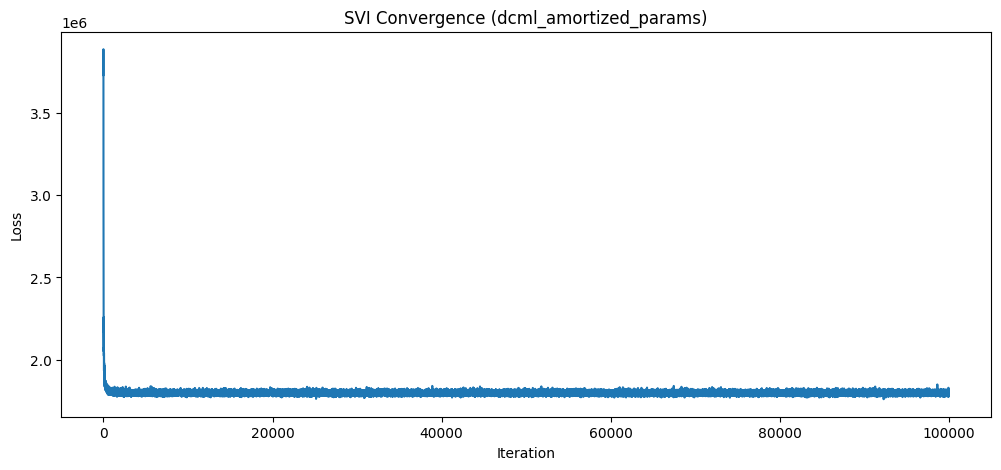

In [24]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=100000, lr=0.1, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

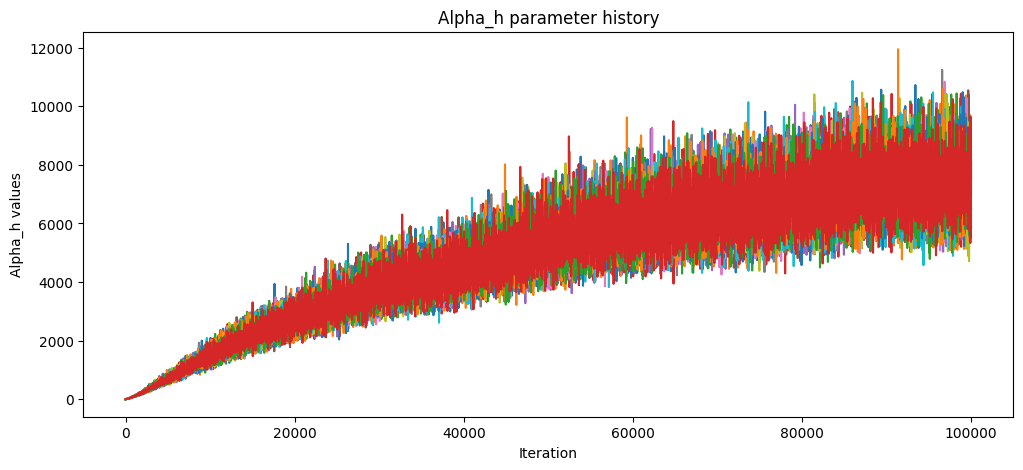

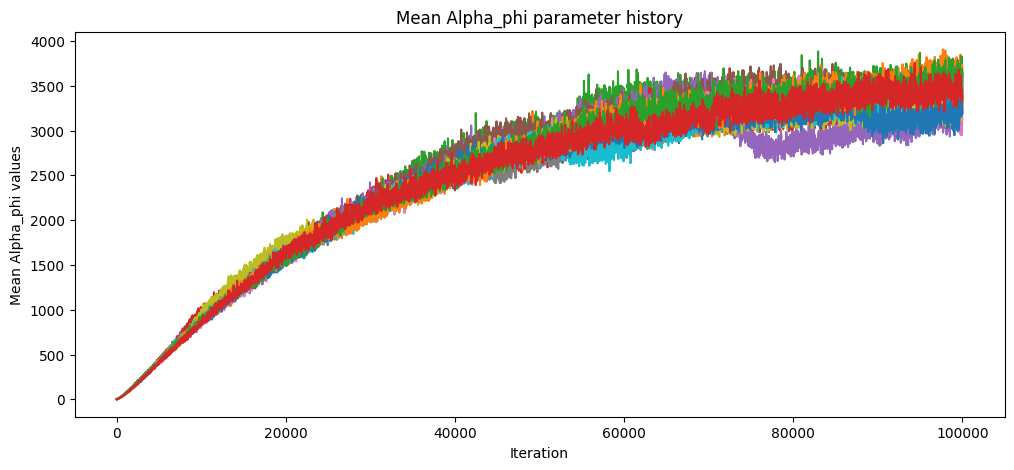

In [25]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

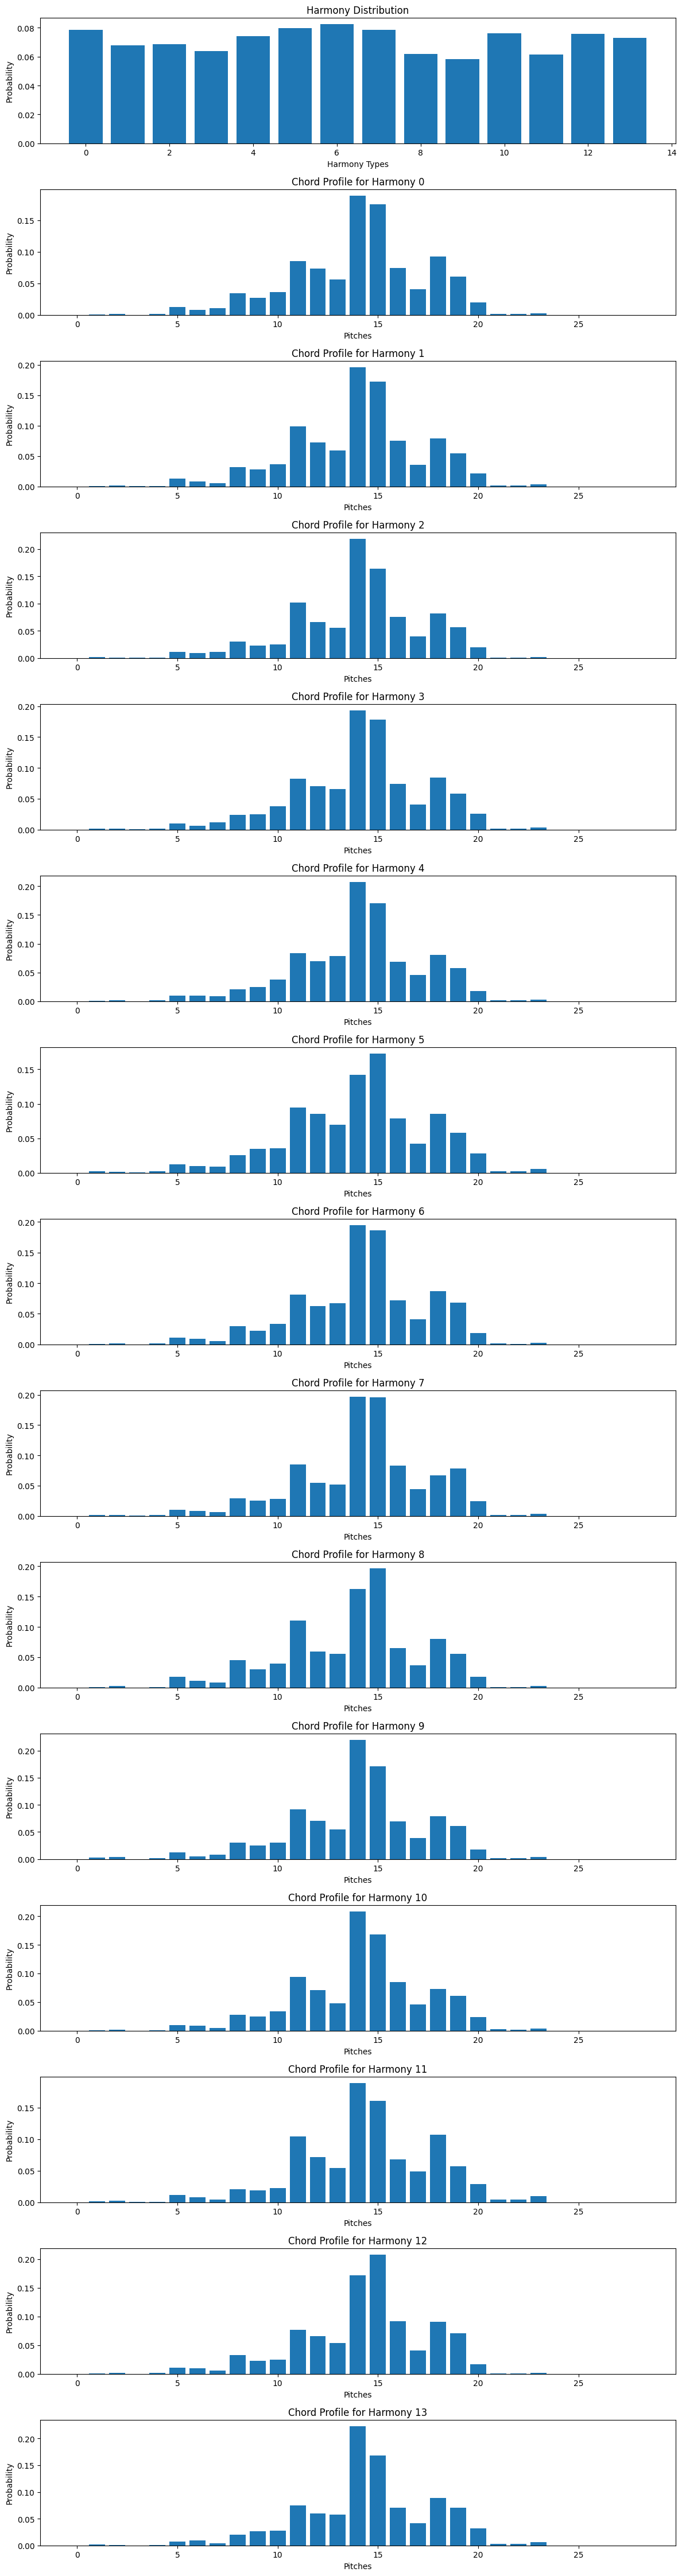

In [26]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")